Задание сделали

Ошметков С.С. Б03-113И

Иванов А.С Б03-114

Токарев С.Е. Б03-114


Задание № 1 Добавьте генератор суммаризации для модели, приведет демонстрацию результата для 5 примеров из теста и 5 собственных примеров.


Задание № 2 Добавьте оценку для модели с помощью ROUGE metric


Задание № 3 Добавьте визуализацию механизма attention после обучения модели на конкретном примере (не менее 3 примеров).


Задание № 4 Сделайте общими матрицы эмбеддингов - их тут три (входные в энкодер и декодер + выход декодера).


Задание № 5 Замените функцию ошибки на LabelSmoothing.


Задание № 6 Добавьте предодученные эмбединги при обучении модели, покажите разницу в метрике до и после.


Ошметков С.С - Задание № 1, Задание № 2


Иванов А.С - Задание № 3, Задание № 5


Токарев С.Е. - Задание № 4, Задание № 6







In [1]:
!wget -O news.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1hIVVpBqM6VU4n3ERkKq4tFaH4sKN0Hab"
!unzip news.zip

Archive:  news.zip
  inflating: news.csv                


In [2]:
!pip install torchtext==0.6.0
!pip install sacremoses==0.0.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=dae2910b56b2ecfbd7c63415d43c3bba37c2f9c385415fbb79f505f296d2602f
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [8]:
import os
import re
import dill
import heapq
import random
import numpy as np
import pandas as pd
import random
import math
import spacy
from nltk.corpus import stopwords
from torchtext.vocab import Vocab
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sentencepiece as sp
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchtext.data import Field, Example, Dataset, BucketIterator
from collections import Counter
from tqdm.auto import tqdm
import nltk
from rouge_score import rouge_scorer
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm



%matplotlib inline

In [9]:
if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

np.random.seed(42)
print(DEVICE)

cuda


# Abstactive Summarization

Задача - по тексту сгенерировать выдержку из него.

Например, попробуем по новостям генерировать заголовки:

In [7]:
!shuf -n 10 news.csv

450948,"Больше половины американцев считают, что кандидат в вице-президенты США от республиканцев Сара Пэйлин не подготовлена к той должности, на которую претендует, сообщает AFP. По данным исследования, проведенного New York Times и CBS News, 59 процентов опрошенных назвали губернатора Аляски недостаточно опытной для этой работы. 35 процентов уверены, что она справится с вице-президентской должностью. Более 40 процентов американцев заявили, что им не нравится Сара Пэйлин. В то же время у 36 процентов опрошенных создалось благоприятное мнение о кандидате в вице-президенты. 24 процента не смогли определиться со своим отношением к Пэйлин. Агентство отмечает, что месяц назад всего 50 процентов американцев считали Сару Пэйлин недостаточно опытной.",Американцы сочли Сару Пэйлин недостаточно опытной для поста вице-президента
490404,"В бакинском офисе партии ""Ени Азербайджан"" (Новый Азербайджан), которую возглавляет президент страны Ильхам Алиев, совершена кража, сообщает Day.Az. Из сейфа в

Токенизируем их. Будем использовать единый словарь для текста и заголовков.

In [4]:
!pip install nltk

In [5]:
!pip install spacy

In [6]:
!python -m spacy download ru_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 113.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
nltk.download('stopwords')
ru_stopwords = set(stopwords.words("russian"))
nlp = spacy.load("ru_core_news_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def spacy_tokenize(text):
    return [
        token.text.lower()
        for token in nlp(text)
        if not token.is_space and not token.is_punct and token.text.lower() not in ru_stopwords
    ]

In [155]:
BOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
UNK_TOKEN = "<unk>"
PAD_TOKEN = "<pad>"

word_field = Field(tokenize=spacy_tokenize, init_token=BOS_TOKEN, eos_token=EOS_TOKEN, unk_token=UNK_TOKEN, pad_token=PAD_TOKEN, lower=False, include_lengths=True)
fields = [("source", word_field), ("target", word_field)]

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
examples_path = "/content/drive/MyDrive/Colab Notebooks/data/Set_of_examples.pkl"
if os.path.exists(examples_path):
    with open(examples_path, "rb") as f:
        examples = dill.load(f)
else:
    data = pd.read_csv("news.csv", delimiter=",", encoding="utf-8-sig")
    data = data.sample(n=5000, random_state=42)
    examples = []
    for _, row in tqdm(data.iterrows(), total=len(data)):
        source_text = word_field.preprocess(row.text)
        target_text = word_field.preprocess(row.title)
        examples.append(Example.fromlist([source_text, target_text], fields))

    with open(examples_path, "wb") as f:
        dill.dump(examples, f)

Построим датасеты:

In [15]:
dataset = Dataset(examples, fields)

train_dataset, test_dataset = dataset.split(split_ratio=0.85)

print('Train size =', len(train_dataset))
print('Test size =', len(test_dataset))

word_field.build_vocab(train_dataset, min_freq=7)
print('Vocab size =', len(word_field.vocab))

DEVICE = torch.device("cuda")
train_iter, test_iter = BucketIterator.splits(
    datasets=(train_dataset, test_dataset), batch_sizes=(16, 32), shuffle=True, device=DEVICE, sort=False
)

Train size = 4250
Test size = 750
Vocab size = 7734


In [156]:
token_counter = Counter()
for ex in train_dataset.examples:
    token_counter.update(ex.source)

for stopword in ru_stopwords:
    if stopword in token_counter:

        token_counter[stopword] = max(1, token_counter[stopword] // 10)

In [157]:
word_field.vocab = Vocab(token_counter, specials=[UNK_TOKEN, PAD_TOKEN, BOS_TOKEN, EOS_TOKEN], min_freq=10)

In [18]:
embedding_dim = 300
embedding_matrix = np.random.normal(scale=0.01, size=(len(word_field.vocab), embedding_dim))
vectors = {}
for i in range(len(embedding_matrix)):
    if word_field.vocab.itos[i] not in vectors:
        norm = np.linalg.norm(embedding_matrix[i])
        if norm > 0:
            embedding_matrix[i] /= norm

for i, token in enumerate(word_field.vocab.itos):
    if token in vectors:
        embedding_matrix[i] = vectors[token]

pretrained_embeddings = torch.tensor(embedding_matrix, dtype=torch.float)

In [19]:
print("vocab size:", len(word_field.vocab))

vocab size: 4870


In [20]:
for word in ['путин', 'взрыв', 'власти', 'россия', 'сша', 'мир', 'физтех']:
    idx = word_field.vocab.stoi.get(word)
    if idx is not None:
        print(f"Word '{word}' index {idx}, embedding: {pretrained_embeddings[idx][:5]}")
    else:
        print(f"Word '{word}' not found in vocabulary.")

Word 'путин' index 456, embedding: tensor([ 0.0965, -0.1425,  0.0208, -0.0609, -0.0674])
Word 'взрыв' index 172, embedding: tensor([ 0.0008, -0.0014,  0.0433, -0.1093,  0.0260])
Word 'власти' index 128, embedding: tensor([-0.0419, -0.0091,  0.0539,  0.0874,  0.0619])
Word 'россия' index 468, embedding: tensor([ 0.0251, -0.0298,  0.0688,  0.0063,  0.0093])
Word 'сша' index 24, embedding: tensor([ 0.0077,  0.0036,  0.0447, -0.0464, -0.0958])
Word 'мир' index 1419, embedding: tensor([0.0191, 0.0442, 0.0515, 0.0303, 0.0626])
Word 'физтех' not found in vocabulary.


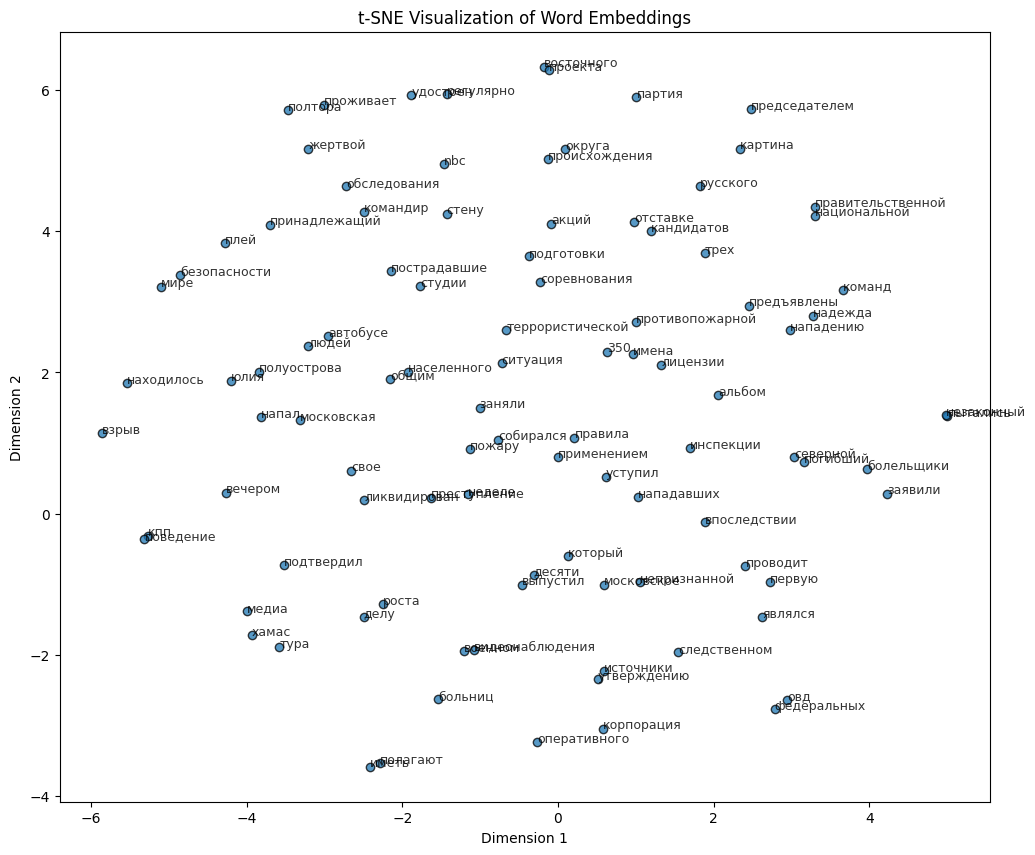

In [21]:
selected_words = np.random.choice(word_field.vocab.itos, size=100, replace=False)
word_vectors = np.array([embedding_matrix[word_field.vocab.stoi[word]] for word in selected_words])

tsne_model = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne_model.fit_transform(word_vectors)

plt.figure(figsize=(12, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.75, edgecolors='k')

for i, word in enumerate(selected_words):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9, alpha=0.8)

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("t-SNE Visualization of Word Embeddings")

plt.show()

In [22]:
sorted_vocab = sorted(word_field.vocab.freqs.items(), key=lambda item: item[1], reverse=True)

print("\nTop 20 most frequently occurring words:")
for rank, (word, frequency) in enumerate(sorted_vocab[:20], start=1):
    print(f"{rank}. {word}: {frequency}")


Top 20 most frequently occurring words:
1. сообщает: 2461
2. года: 1051
3. время: 838
4. человек: 836
5. также: 834
6. новости: 827
7. результате: 804
8. риа: 782
9. россии: 771
10. около: 663
11. данным: 653
12. словам: 543
13. ссылкой: 535
14. это: 523
15. году: 498
16. пока: 497
17. интерфакс: 497
18. агентство: 495
19. который: 485
20. передает: 484


## Seq2seq for Abstractive Summarization

Вообще задача не сильно отличается от машинного перевода:

![](https://image.ibb.co/jAf3S0/2018-11-20-9-42-17.png)
*From [Get To The Point: Summarization with Pointer-Generator Networks](https://arxiv.org/pdf/1704.04368.pdf)*

Тут на каждом шаге декодер подглядывает на все токены - точнее, их эмбеддинги после BiRNN.

Возникает вопрос - а зачем вообще RNN, если потом все равно будем смотреть на всё.

# Transformer

Из этой идеи - отказ от RNN - и получился Transformer.

![](https://hsto.org/webt/59/f0/44/59f04410c0e56192990801.png)  
*From Attention is all you need*

Как в случае с RNN мы на каждом шаге применяем одну и ту же операцию (ячейку LSTM) к текущему входу, так и здесь - только теперь связей между timestamp'ами нет и можно обрабатывать их почти параллельно.

*Код дальше очень сильно опирается на шикарную статью [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html).*

## Encoder

Начнем с энкодера:

![](http://jalammar.github.io/images/t/transformer_resideual_layer_norm.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

Он представляет из себя последовательность одинаковых блоков с self-attention + полносвязными слоями.

Можно представить, что это - ячейка LSTM: она тоже применяется к каждому входу с одинаковыми весами. Разница основная в отсутствии рекуррентных связей: за счет этого энкодер может применяться одновременно ко всем входам батча.

### Positional Encoding

Нужно как-то кодировать информацию о том, в каком месте в предложении стоит токен. Авторы предложили делать так:
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$
$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$

где $(pos, i)$ - позиция в предложении и индекс в скрытом векторе размерности до $d_{model}$.

In [23]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

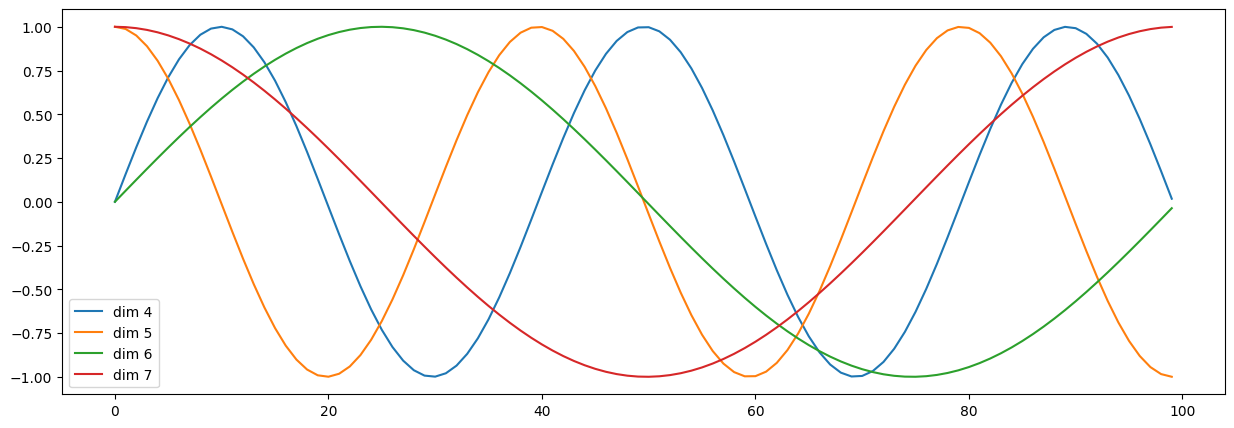

In [24]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

В итоге эмбеддинги токена получается как сумма обычного эмбеддинга и эмбеддинга позиции:  
![](http://jalammar.github.io/images/t/transformer_positional_encoding_vectors.png)  
*From [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)*

### Residual Connection

Разберем блок энкодера - повторяющейся N раз комбинации операций на первом рисунке.

Самое простое здесь - residual connection. Вместо к выходу произвольной функции $F$ прибавляется её вход
$$y = F(x) \quad \to \quad y = F(x) + x$$

Идея в том, что обычные сети сложно делать слишком глубокими - градиенты затухают. А через этот residual вход $x$ градиентам течь ничего не стоит. В итоге в картинках благодаря таким блокам получилось настакать дофига слоев и улучшить качество (см. ResNet).

Ничего не мешает нам поступить также.

In [25]:
class ResidualBlock(nn.Module):
    def __init__(self, size, dropout_rate):
        super().__init__()
        self._norm = LayerNorm(size)
        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, inputs, sublayer):
        return inputs + self._dropout(sublayer(self._norm(inputs)))

### Layer Norm

Дополнительно применяется нормализация LayerNorm.

**Batch normalization**  
Мы вообще не разбирали, но BatchNorm работает так:
$$\mu_j = \frac{1}{m}\sum_{i=1}^{m}x_{ij} \\    \sigma_j^2 = \frac{1}{m}\sum_{i=1}^{m}(x_{ij} - \mu_j)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_j}{\sqrt{\sigma_j^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

На каждом батче эти $\mu$ и $\sigma$ пересчитываются, обновляя статистики. На инференсе используются накопленные статистики.

Основной его недостаток - он плохо работает с рекуррентными сетями. Чтобы побороть это придумали:

**Layer normalization**  
А сейчас мы будем пользоваться немного другими формулами:
$$\mu_i = \frac{1}{m}\sum_{j=1}^{m}x_{ij} \\    \sigma_i^2 = \frac{1}{m}\sum_{j=1}^{m}(x_{ij} - \mu_i)^2 \\    \hat{x}_{ij} = \frac{x_{ij} - \mu_i}{\sqrt{\sigma_i^2 + \epsilon}}$$
$$y_{ij} = \gamma \ \hat{x}_{ij} + \beta$$

Разницу с ходу не видно, но она есть:
![](https://image.ibb.co/hjtuX0/layernorm.png)  
*From [Weight Normalization and Layer Normalization Explained ](http://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/)*

Если в BatchNorm статистики считаются для каждой фичи усреднением по батчу, то теперь - для каждого входа усредением по фичам.

In [26]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super().__init__()

        self._gamma = nn.Parameter(torch.ones(features))
        self._beta = nn.Parameter(torch.zeros(features))
        self._eps = eps

    def forward(self, inputs):
        mean = inputs.mean(-1, keepdim=True)
        std = inputs.std(-1, keepdim=True)
        return self._gamma * (inputs - mean) / (std + self._eps) + self._beta

### Attention

Весь Transformer опирается на идею self-attention. Выглядит это так:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Эмбеддинг слова *it* строится как комбинация всех эмбеддингов предложения.

В статье придумали делать такой аттеншен:

$$\mathrm{Attention}(Q, K, V) = \mathrm{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Это примерно как dot-attention на прошлом занятии: запрос (**Q**uery) умножается на ключи (**K**ey) скалярно, затем берется софтмакс - получаются оценки того, насколько интересны разные таймстемпы из значений (**V**alue).

Например, $\mathrm{emb}(\text{it}) = \mathrm{Attention}(\text{it}, \ldots\text{because it was too tired}, \ldots\text{because it was too tired})$.

Только теперь ещё с параметром $\frac{1}{\sqrt{d_k}}$, где $d_k$ - это размерность ключа. Утверждается, это работает лучше при больших размерностях ключа $d_k$.

In [27]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()

        self._dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, mask):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = F.softmax(scores, dim=-1)
        p_attn = self._dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

### Multi-Head Attention

![](https://hsto.org/webt/59/f0/44/59f0440f1109b864893781.png)

Важная идея, почему attention (и, главное, self-attention) заработал - использование нескольких голов (multi-head).

Вообще, когда мы делаем attention - мы определяем похожесть ключа и запроса. Многоголовость помогает (должна) определять эту похожесть по разным критериям - синтаксически, семантически и т.д.

Например, на картинке используется две головы и одна голова смотрит на *the animal* при генерации *it*, вторая - на *tired*:

![](http://jalammar.github.io/images/t/transformer_self-attention_visualization_2.png)  
*From [Tensor2Tensor Tutorial](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)*

Применяется это таким образом:

$$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$
    
где $W^Q_i \in \mathbb{R}^{d_{model} \times d_k}, W_i^K \in \mathbb{R}^{d_{model} \times d_k}, W^V_i \in \mathbb{R}^{d_{model} \times d_v}, W^O \in \mathbb{R}^{hd_v \times d_{model}}$.

В оригинальной статье использовали $h=8$, $d_k=d_v=d_{\text{model}}/h=64$.

Процесс применения такой:
![](http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png)  
*From Illustrated Transformer*

In [28]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, heads_count, d_model, dropout_rate=0.1):
        super().__init__()

        assert d_model % heads_count == 0

        self._d_k = d_model // heads_count
        self._heads_count = heads_count
        self._attention = ScaledDotProductAttention(dropout_rate)
        self._attn_probs = None

        self._w_q = nn.Linear(d_model, d_model)
        self._w_k = nn.Linear(d_model, d_model)
        self._w_v = nn.Linear(d_model, d_model)
        self._w_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        query = self._w_q(query).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        key = self._w_k(key).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        value = self._w_v(value).view(nbatches, -1, self._heads_count, self._d_k).transpose(1, 2)
        x, self._attn_probs = self._attention(query, key, value, mask)

        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self._heads_count * self._d_k)
        x = self._w_o(x)
        return x

### Position-wise Feed-Forward Networks

Линейный блок в энкодере выглядит так:
$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

In [29]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()

        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        return self.w_2(self.dropout(F.relu(self.w_1(inputs))))

### Encoder block

Соберем все в блок:

In [30]:
class EncoderBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, mask):
        outputs = self._self_attention_block(inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, mask))
        return self._feed_forward_block(outputs, self._feed_forward)

In [31]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, embeddings, save_probs = False):
        super().__init__()

        self._emb = embeddings

        block = lambda: EncoderBlock(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

        self.save_probs = save_probs
        self.attn_probs = []

    def forward(self, inputs, mask):
        inputs = self._emb(inputs)
        self.attn_probs.clear()
        for block in self._blocks:
            inputs = block(inputs, mask)
            if self.save_probs:
                self.attn_probs.append(block._self_attn._attn_probs)

        return self._norm(inputs)

## Decoder

![](https://hsto.org/webt/59/f0/44/59f0440f7d88f805415140.png)

Блок декодера (серая часть) состоит уже из трех частей:
1. Сперва - тот же self-attention, что и в энкодере
2. Затем - стандартный attention на выходы из энкодера + текущее состояние декодера (такой же был в seq2seq with attention)
3. Наконец - feed-forward блок

Всё это, конечно, с residual связями.

In [32]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, encoder_attn, feed_forward, dropout_rate):
        super().__init__()

        self._self_attn = self_attn
        self._encoder_attn = encoder_attn
        self._feed_forward = feed_forward
        self._self_attention_block = ResidualBlock(size, dropout_rate)
        self._attention_block = ResidualBlock(size, dropout_rate)
        self._feed_forward_block = ResidualBlock(size, dropout_rate)

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        outputs = self._self_attention_block(
            inputs, lambda inputs: self._self_attn(inputs, inputs, inputs, target_mask)
        )
        outputs = self._attention_block(
            outputs, lambda inputs: self._encoder_attn(inputs, encoder_output, encoder_output, source_mask)
        )
        return self._feed_forward_block(outputs, self._feed_forward)

In [33]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, embeddings, out_layer, save_probs = False):
        super().__init__()
        self._out_layer = out_layer
        self._emb = embeddings

        block = lambda: DecoderLayer(
            size=d_model,
            self_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            encoder_attn=MultiHeadedAttention(heads_count, d_model, dropout_rate),
            feed_forward=PositionwiseFeedForward(d_model, d_ff, dropout_rate),
            dropout_rate=dropout_rate
        )
        self._blocks = nn.ModuleList([block() for _ in range(blocks_count)])
        self._norm = LayerNorm(d_model)

        self.save_probs = save_probs
        self.self_attn_probs = []
        self.enc_attn_probs = []

    def forward(self, inputs, encoder_output, source_mask, target_mask):
        inputs = self._emb(inputs)

        self.self_attn_probs.clear()
        self.enc_attn_probs.clear()

        for block in self._blocks:
            inputs = block(inputs, encoder_output, source_mask, target_mask)
            if self.save_probs:
                self.self_attn_probs.append(block._self_attn._attn_probs)
                self.enc_attn_probs.append(block._encoder_attn._attn_probs)
        return self._out_layer(self._norm(inputs))

В декодере нужно аттентиться только на предыдущие токены - сгенерируем маску для этого:

In [34]:
def subsequent_mask(size):
    mask = torch.ones(size, size, device=DEVICE).triu_()
    return mask.unsqueeze(0) == 0

In [35]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0].cpy().numpy())

AttributeError: 'Tensor' object has no attribute 'cpy'

<Figure size 500x500 with 0 Axes>

## Полная модель

In [36]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)


class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    """
    def __init__(self, source_vocab_size, target_vocab_size, d_model=256, d_ff=1024,
                 blocks_count=4, heads_count=8, dropout_rate=0.1, save_probs=False, use_shared_emb=False,
                 pretrained_embeddings=None):
        super().__init__()

        self._out_layer = nn.Linear(d_model, target_vocab_size)
        self.d_model = d_model


        if pretrained_embeddings is not None:
            self.embedding_layer = nn.Embedding(source_vocab_size, 300)
            self.embedding_layer.weight.data.copy_(pretrained_embeddings)
            self.embedding_layer.weight.requires_grad = True

            self.embedding_proj = nn.Linear(300, d_model)
            self._pos_enc = PositionalEncoding(d_model, dropout_rate)
            self.enc_emb = nn.Sequential(self.embedding_layer, self.embedding_proj, self._pos_enc)

            if use_shared_emb:
                self.dec_emb = self.enc_emb
                self._out_layer.weight = self.dec_emb[0].weight
            else:
                self.embedding_layer2 = nn.Embedding(target_vocab_size, 300)
                self.embedding_layer2.weight.data.copy_(pretrained_embeddings)
                self.embedding_layer2.weight.requires_grad = True

                self.embedding_proj2 = nn.Linear(300, d_model)
                self._pos_enc2 = PositionalEncoding(d_model, dropout_rate)
                self.dec_emb = nn.Sequential(self.embedding_layer2, self.embedding_proj2, self._pos_enc2)

        else:
            if use_shared_emb:
                shared_embedding = nn.Embedding(source_vocab_size, d_model)
                self.enc_emb = nn.Sequential(shared_embedding, PositionalEncoding(d_model, dropout_rate))
                self.dec_emb = self.enc_emb
                self._out_layer.weight = self.dec_emb[0].weight
            else:
                self.enc_emb = nn.Sequential(
                    nn.Embedding(source_vocab_size, d_model),
                    PositionalEncoding(d_model, dropout_rate)
                )
                self.dec_emb = nn.Sequential(
                    nn.Embedding(target_vocab_size, d_model),
                    PositionalEncoding(d_model, dropout_rate)
                )

        self.encoder = Encoder(source_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, self.enc_emb, save_probs)
        self.decoder = Decoder(target_vocab_size, d_model, d_ff, blocks_count, heads_count, dropout_rate, self.dec_emb, self._out_layer, save_probs)

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, source_inputs, target_inputs, source_mask, target_mask):
        encoder_output = self.encoder(source_inputs, source_mask)
        return self.decoder(target_inputs, encoder_output, source_mask, target_mask)


In [37]:
def make_mask(source_inputs, target_inputs, pad_idx):
    source_mask = (source_inputs != pad_idx).unsqueeze(-2)
    target_mask = (target_inputs != pad_idx).unsqueeze(-2)
    target_mask = target_mask & subsequent_mask(target_inputs.size(-1)).type_as(target_mask)
    return source_mask, target_mask


def convert_batch(batch, pad_idx=1):
    source_inputs, _ = batch.source
    target_inputs, _ = batch.target

    source_inputs = source_inputs.transpose(0, 1)
    target_inputs = target_inputs.transpose(0, 1)

    source_mask, target_mask = make_mask(source_inputs, target_inputs, pad_idx)
    return source_inputs, target_inputs, source_mask, target_mask

In [38]:
batch = next(iter(train_iter))

In [39]:
model = EncoderDecoder(
    source_vocab_size=len(word_field.vocab),
    target_vocab_size=len(word_field.vocab),
    d_model=512,
    heads_count=8,
    pretrained_embeddings=pretrained_embeddings,
    use_shared_emb = None
).to(DEVICE)

out = model(*convert_batch(batch))

In [40]:
out.shape, len(word_field.vocab)

(torch.Size([16, 11, 4870]), 4870)

## Оптимизатор

Тоже очень важно в данной модели - использовать правильный оптимизатор

In [41]:
class NoamOpt(object):
    def __init__(self, model_size, factor=2, warmup=4000, optimizer=None):
        if optimizer is not None:
            self.optimizer = optimizer
        else:
            self.optimizer = optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

Идея в том, чтобы повышать learning rate в течении первых warmup шагов линейно, а затем понижать его по сложной формуле:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

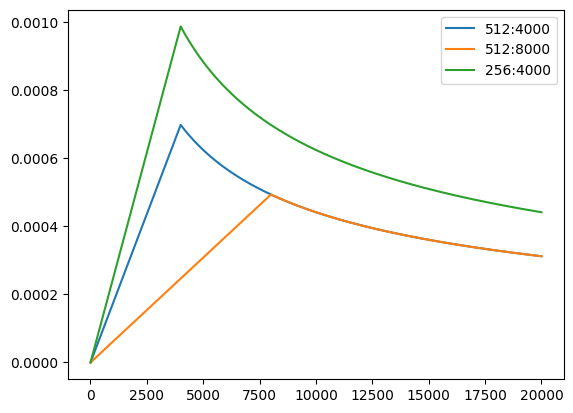

In [42]:
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

In [43]:
class LabelSmoothing(nn.Module):
    def __init__(self, smoothing=0.1, vocab_size=None, ignore_index=-100):
        super().__init__()
        self.smoothing = smoothing
        self.vocab_size = vocab_size
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)

        with torch.no_grad():
            smooth_dist = torch.full_like(pred, self.smoothing / (self.vocab_size - 2))
            smooth_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)

            mask = target.ne(self.ignore_index).unsqueeze(1)
            smooth_dist *= mask

        loss = torch.sum(-smooth_dist * pred, dim=-1)
        return loss.mean()


In [44]:
def save_metrics(save_path, epoch, metrics):
    metrics['epoch'] = epoch
    df = pd.DataFrame([metrics])

    if not save_path.exists():
        df.to_csv(save_path, index=False)
    else:
        df.to_csv(save_path, mode='a', header=False, index=False)

## Тренировка модели

In [45]:
tqdm.get_lock().locks = []

def do_epoch(model, criterion, data_iter, optimizer=None, name=None, teacher_forcing_ratio=0.5):
    epoch_loss = 0
    total_rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}

    is_train = optimizer is not None
    name = name or ''
    model.train(is_train)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    batches_count = len(data_iter)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count, desc=name) as progress_bar:
            for batch in data_iter:
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                encoder_output = model.encoder(source_inputs, source_mask)

                batch_size, target_len = target_inputs.shape

                output_teacher = target_inputs[:, :1]
                output_autoregressive = target_inputs[:, :1]

                for t in range(1, target_len):
                    logits_teacher = model.decoder(output_teacher, encoder_output, source_mask, target_mask[:, :t, :t])
                    logits_autoregressive = model.decoder(output_autoregressive, encoder_output, source_mask, target_mask[:, :t, :t])

                    next_token = logits_teacher[:, -1, :].argmax(dim=-1)

                    teacher_force = random.random() < teacher_forcing_ratio
                    next_input_teacher = target_inputs[:, t] if teacher_force else next_token
                    output_teacher = torch.cat((output_teacher, next_input_teacher.unsqueeze(1)), dim=1)

                    # Автоагрессия
                    output_autoregressive = torch.cat((output_autoregressive, next_token.unsqueeze(1)), dim=1)

                # Вычисление потерь
                logits = model.decoder(output_teacher[:, :-1], encoder_output, source_mask, target_mask[:, :-1, :-1])
                loss = criterion(logits.view(-1, logits.shape[-1]), target_inputs[:, 1:].view(-1))
                epoch_loss += loss.item()

                # Вычисление метрик ROUGE
                pred_sentences = decode_tokens(output_autoregressive, vocab)
                target_sentences = decode_tokens(target_inputs[:, 1:], vocab)

                for pred, ref in zip(pred_sentences, target_sentences):
                    scores = scorer.score(ref, pred)
                    for key in total_rouge_scores:
                        total_rouge_scores[key] += scores[key].fmeasure / batch_size

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_postfix(Loss=loss.item(), PPX=math.exp(loss.item()))

    avg_loss = epoch_loss / batches_count
    avg_rouge_scores = {key: val / batches_count for key, val in total_rouge_scores.items()}

    return {
        'loss': avg_loss,
        'ppx': math.exp(avg_loss),
        **avg_rouge_scores
    }

def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None,
        save_path1=None, patience=7, start_epoch=0, best_val_loss=float('inf'),
        train_metrics_file=Path('train_metrics.csv'), val_metrics_file=Path('val_metrics.csv')):

    epochs_no_improve = 0
    best_model_state = None

    initial_teacher_forcing = 0.7
    min_teacher_forcing = 0.1
    decay_rate = 0.03

    for epoch in range(start_epoch, start_epoch + epochs_count):
        name_prefix = f"[{epoch + 1}/{start_epoch + epochs_count}] "
        teacher_forcing_ratio = max(min_teacher_forcing, initial_teacher_forcing - decay_rate * epoch)

        train_metrics = do_epoch(model, criterion, train_iter, optimizer, name_prefix + "Train:", teacher_forcing_ratio)
        save_metrics(train_metrics_file, epoch, train_metrics)

        if val_iter is not None:
            val_metrics = do_epoch(model, criterion, val_iter, None, name_prefix + "Val:", teacher_forcing_ratio=0.0)
            save_metrics(val_metrics_file, epoch, val_metrics)

            if val_metrics['loss'] < best_val_loss - 1e-4:
                best_val_loss = val_metrics['loss']
                best_model_state = model.state_dict()
                epochs_no_improve = 0
                print(f"New best model found! val_loss={best_val_loss:.4f}")

                if save_path1:
                    torch.save({
                        'model_state_dict': best_model_state,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'noam_step': optimizer._step,
                        'best_val_loss': best_val_loss,
                        'epoch': epoch
                    }, save_path1)
            else:
                epochs_no_improve += 1
                print(f"No improvement. Patience: {epochs_no_improve}/{patience}")
                if epochs_no_improve >= patience:
                    print("Early stopping triggered!")
                    if best_model_state:
                        model.load_state_dict(best_model_state)
                    break

        print(f"Epoch {epoch + 1}: Teacher Forcing Ratio = {teacher_forcing_ratio:.2f}")

def decode_tokens(tensor, vocab, skip_tokens=('<pad>', '<sos>', '<eos>')):
    """
    Converts token indices into readable sentences, skipping special tokens.

    Args:
        tensor (torch.Tensor): Tensor of shape [batch_size, seq_len].
        vocab (torchtext.vocab.Vocab): Vocabulary object to map indices to words.
        skip_tokens (tuple): Tokens to exclude.

    Returns:
        list[str]: List of decoded sentences.
    """
    skip_ids = {vocab.stoi[token] for token in skip_tokens if token in vocab.stoi}
    return [" ".join(vocab.itos[token.item()] for token in seq if token.item() not in skip_ids) for seq in tensor]


In [46]:
tqdm.get_lock().locks = []
from rouge_score import rouge_scorer

def do_epoch(model, criterion, data_iter, optimizer=None, name=None, teacher_forcing_ratio=0.5):
    epoch_loss = 0
    total_rouge1 = 0
    total_rouge2 = 0
    total_rougeL = 0

    is_train = optimizer is not None
    name = name or ''
    model.train(is_train)

    batches_count = len(data_iter)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                source_inputs, target_inputs, source_mask, target_mask = convert_batch(batch)
                encoder_output = model.encoder(source_inputs, source_mask)

                batch_size, target_len = target_inputs.size()

                output_teacher = target_inputs[:, 0].unsqueeze(1)  # Для обучения (с Teacher Forcing)
                output_autoregressive = target_inputs[:, 0].unsqueeze(1)  # Для ROUGE (без Teacher Forcing)

                for t in range(1, target_len):
                    # Общая часть: вычисление logits для обоих режимов
                    logits_teacher = model.decoder(output_teacher, encoder_output, source_mask, target_mask[:, :t, :t])
                    logits_autoregressive = model.decoder(output_autoregressive, encoder_output, source_mask, target_mask[:, :t, :t])

                    next_token_logits = logits_teacher[:, -1, :]
                    next_token = next_token_logits.argmax(dim=-1)

                    # Teacher Forcing для обучения
                    teacher_force = random.random() < teacher_forcing_ratio
                    next_input_teacher = target_inputs[:, t] if teacher_force else next_token
                    next_input_teacher = next_input_teacher.unsqueeze(1)
                    output_teacher = torch.cat((output_teacher, next_input_teacher), dim=1)

                    # Авторегрессия для ROUGE
                    next_input_autoregressive = next_token
                    output_autoregressive = torch.cat((output_autoregressive, next_input_autoregressive.unsqueeze(1)), dim=1)

                # Вычисление потерь на предсказаниях с Teacher Forcing
                logits = model.decoder(output_teacher[:, :-1], encoder_output, source_mask, target_mask[:, :-1, :-1])
                logits = logits.contiguous().view(-1, logits.shape[-1])
                target = target_inputs[:, 1:].contiguous().view(-1)
                loss = criterion(logits, target)
                epoch_loss += loss.item()


                # Вычисление ROUGE на авторегрессионных предсказаниях
                pred_sentences = decode_tokens(output_autoregressive, vocab)
                target_sentences = decode_tokens(target_inputs[:, 1:], vocab)  # Игнорируем начальный токен


                # Считаем метрики Rouge
                batch_rouge1 = 0
                batch_rouge2 = 0
                batch_rougeL = 0
                for pred, ref in zip(pred_sentences, target_sentences):
                    scores = scorer.score(ref, pred)
                    batch_rouge1 += scores['rouge1'].fmeasure
                    batch_rouge2 += scores['rouge2'].fmeasure
                    batch_rougeL += scores['rougeL'].fmeasure

                total_rouge1 += batch_rouge1 / batch_size
                total_rouge2 += batch_rouge2 / batch_size
                total_rougeL += batch_rougeL / batch_size


                if optimizer:
                    optimizer.optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                progress_bar.update()
                progress_bar.set_description(
                    '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                        name, loss.item(), math.exp(loss.item()),
                        batch_rouge1 / batch_size, batch_rouge2 / batch_size, batch_rougeL / batch_size
                    )
                )


            avg_loss = epoch_loss / batches_count
            avg_rouge1 = total_rouge1 / batches_count
            avg_rouge2 = total_rouge2 / batches_count
            avg_rougeL = total_rougeL / batches_count

            progress_bar.set_description(
                '{:>5s} Loss = {:.5f}, PPX = {:.2f}, R1 = {:.3f}, R2 = {:.3f}, RL = {:.3f}'.format(
                    name, avg_loss, math.exp(avg_loss), avg_rouge1, avg_rouge2, avg_rougeL
                )
            )
            progress_bar.refresh()

    return {
        'loss': avg_loss,
        'ppx': math.exp(avg_loss),
        'rouge1': avg_rouge1,
        'rouge2': avg_rouge2,
        'rougeL': avg_rougeL
    }

def fit(model, criterion, optimizer, train_iter, epochs_count=1, val_iter=None,
        save_path1=None, patience=7, start_epoch=0, best_val_loss=float('inf'),
        train_metrics_file = Path('/content/drive/MyDrive/Colab Notebooks/data/train_metrics.csv'), val_metrics_file = Path('/content/drive/MyDrive/Colab Notebooks/data/val_metrics.csv')):

    epochs_no_improve = 0
    best_model_state = None

    initial_teacher_forcing = 0.7
    min_teacher_forcing = 0.1
    decay_rate = 0.03

    for epoch in range(start_epoch, start_epoch + epochs_count):
        name_prefix = f"[{epoch + 1} / {start_epoch + epochs_count}] "
        teacher_forcing_ratio = max(min_teacher_forcing, initial_teacher_forcing - decay_rate * epoch)

        train_metrics = do_epoch(model, criterion, train_iter, optimizer, name_prefix + "Train:", teacher_forcing_ratio)
        train_loss = train_metrics['loss']
        save_metrics(train_metrics_file,epoch,train_metrics)
        if val_iter is not None:
            val_metrics = do_epoch(model, criterion, val_iter, None, name_prefix + "Val:", teacher_forcing_ratio=0.0)
            val_loss = val_metrics['loss']
            save_metrics(val_metrics_file,epoch,val_metrics)



            if val_loss < best_val_loss - 1e-4:  # небольшая дельта, чтобы избежать флуктуаций
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                epochs_no_improve = 0
                print(f"New best model found! val_loss={val_loss:.4f}")
                if save_path1:
                    torch.save({
                        'model_state_dict': best_model_state,
                        'optimizer_state_dict': optimizer.optimizer.state_dict(),
                        'noam_step': optimizer._step,
                        'best_val_loss': best_val_loss,
                        'epoch': epoch
                    }, save_path1)
            else:
                epochs_no_improve += 1
                print(f"No improvement. Patience: {epochs_no_improve}/{patience}")
                if epochs_no_improve >= patience:
                    print("Early stopping triggered!")
                    if save_path1 and best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    break

        print(f"Epoch {epoch + 1}: Teacher Forcing Ratio = {teacher_forcing_ratio:.2f}")





def decode_tokens(tensor, vocab, skip_tokens=('<pad>', '<sos>', '<eos>')):
    """
    Декодирует тензор с индексами токенов в строки, пропуская служебные токены.

    Args:
        tensor (torch.Tensor): Тензор формы [batch_size, seq_len].
        vocab (torchtext.vocab.Vocab): Словарь для преобразования индексов в слова.
        skip_tokens (tuple): Токены, которые нужно пропустить (например, паддинг).

    Returns:
        list[str]: Декодированные предложения.
    """
    sentences = []
    skip_ids = [vocab.stoi[token] for token in skip_tokens if token in vocab.stoi]

    for seq in tensor:
        tokens = [
            vocab.itos[token.item()]
            for token in seq
            if token.item() not in skip_ids
        ]
        sentences.append(" ".join(tokens))

    return sentences

In [47]:
model = EncoderDecoder(source_vocab_size=len(word_field.vocab), target_vocab_size=len(word_field.vocab)).to(DEVICE)
vocab  = word_field.vocab

pad_idx = word_field.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(DEVICE)

optimizer = NoamOpt(model.d_model, factor=2.0, warmup=4000, optimizer=torch.optim.Adam(
    model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

fit(
    model, criterion, optimizer,
    train_iter,
    epochs_count=30,
    val_iter=test_iter,
    save_path1="/content/drive/MyDrive/Colab Notebooks/data/NLP_final.pt",
    patience=7,
    start_epoch=0
)

torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/data/NLP_final.pt")

[1 / 30] Train: Loss = 5.86978, PPX = 354.17, R1 = 0.514, R2 = 0.315, RL = 0.441: 100%|██████████| 266/266 [01:07<00:00,  3.96it/s]
[1 / 30] Val: Loss = 4.32654, PPX = 75.68, R1 = 0.524, R2 = 0.432, RL = 0.524: 100%|██████████| 24/24 [00:04<00:00,  5.10it/s]


New best model found! val_loss=4.3265
Epoch 1: Teacher Forcing Ratio = 0.70


[2 / 30] Train: Loss = 4.37929, PPX = 79.78, R1 = 0.516, R2 = 0.421, RL = 0.516: 100%|██████████| 266/266 [01:07<00:00,  3.95it/s]
[2 / 30] Val: Loss = 4.28139, PPX = 72.34, R1 = 0.519, R2 = 0.427, RL = 0.519: 100%|██████████| 24/24 [00:04<00:00,  5.89it/s]


New best model found! val_loss=4.2814
Epoch 2: Teacher Forcing Ratio = 0.67


[3 / 30] Train: Loss = 4.29004, PPX = 72.97, R1 = 0.515, R2 = 0.420, RL = 0.515: 100%|██████████| 266/266 [01:08<00:00,  3.87it/s]
[3 / 30] Val: Loss = 4.28499, PPX = 72.60, R1 = 0.517, R2 = 0.425, RL = 0.517: 100%|██████████| 24/24 [00:04<00:00,  5.89it/s]


No improvement. Patience: 1/7
Epoch 3: Teacher Forcing Ratio = 0.64


[4 / 30] Train: Loss = 4.22774, PPX = 68.56, R1 = 0.512, R2 = 0.416, RL = 0.512: 100%|██████████| 266/266 [01:06<00:00,  4.01it/s]
[4 / 30] Val: Loss = 4.36366, PPX = 78.54, R1 = 0.517, R2 = 0.426, RL = 0.517: 100%|██████████| 24/24 [00:04<00:00,  5.93it/s]


No improvement. Patience: 2/7
Epoch 4: Teacher Forcing Ratio = 0.61


[5 / 30] Train: Loss = 4.13885, PPX = 62.73, R1 = 0.510, R2 = 0.414, RL = 0.510: 100%|██████████| 266/266 [01:07<00:00,  3.97it/s]
[5 / 30] Val: Loss = 4.39575, PPX = 81.11, R1 = 0.518, R2 = 0.426, RL = 0.518: 100%|██████████| 24/24 [00:04<00:00,  5.49it/s]


No improvement. Patience: 3/7
Epoch 5: Teacher Forcing Ratio = 0.58


[6 / 30] Train: Loss = 4.06350, PPX = 58.18, R1 = 0.510, R2 = 0.414, RL = 0.510: 100%|██████████| 266/266 [01:06<00:00,  3.99it/s]
[6 / 30] Val: Loss = 4.39554, PPX = 81.09, R1 = 0.510, R2 = 0.417, RL = 0.510: 100%|██████████| 24/24 [00:04<00:00,  5.92it/s]


No improvement. Patience: 4/7
Epoch 6: Teacher Forcing Ratio = 0.55


[7 / 30] Train: Loss = 3.99418, PPX = 54.28, R1 = 0.509, R2 = 0.413, RL = 0.509: 100%|██████████| 266/266 [01:07<00:00,  3.97it/s]
[7 / 30] Val: Loss = 4.36859, PPX = 78.93, R1 = 0.518, R2 = 0.426, RL = 0.518: 100%|██████████| 24/24 [00:04<00:00,  5.40it/s]


No improvement. Patience: 5/7
Epoch 7: Teacher Forcing Ratio = 0.52


[8 / 30] Train: Loss = 3.94258, PPX = 51.55, R1 = 0.513, R2 = 0.417, RL = 0.512: 100%|██████████| 266/266 [01:06<00:00,  4.02it/s]
[8 / 30] Val: Loss = 4.32663, PPX = 75.69, R1 = 0.519, R2 = 0.426, RL = 0.518: 100%|██████████| 24/24 [00:04<00:00,  5.93it/s]


No improvement. Patience: 6/7
Epoch 8: Teacher Forcing Ratio = 0.49


[9 / 30] Train: Loss = 3.89823, PPX = 49.31, R1 = 0.506, R2 = 0.410, RL = 0.506: 100%|██████████| 266/266 [01:06<00:00,  3.98it/s]
[9 / 30] Val: Loss = 4.26288, PPX = 71.01, R1 = 0.519, R2 = 0.426, RL = 0.518: 100%|██████████| 24/24 [00:04<00:00,  5.01it/s]


New best model found! val_loss=4.2629
Epoch 9: Teacher Forcing Ratio = 0.46


[10 / 30] Train: Loss = 3.86806, PPX = 47.85, R1 = 0.513, R2 = 0.418, RL = 0.513: 100%|██████████| 266/266 [01:08<00:00,  3.87it/s]
[10 / 30] Val: Loss = 4.26503, PPX = 71.17, R1 = 0.515, R2 = 0.424, RL = 0.515: 100%|██████████| 24/24 [00:04<00:00,  5.72it/s]


No improvement. Patience: 1/7
Epoch 10: Teacher Forcing Ratio = 0.43


[11 / 30] Train: Loss = 3.84212, PPX = 46.62, R1 = 0.514, R2 = 0.418, RL = 0.514: 100%|██████████| 266/266 [01:06<00:00,  4.00it/s]
[11 / 30] Val: Loss = 4.42851, PPX = 83.81, R1 = 0.501, R2 = 0.406, RL = 0.500: 100%|██████████| 24/24 [00:04<00:00,  5.38it/s]


No improvement. Patience: 2/7
Epoch 11: Teacher Forcing Ratio = 0.40


[12 / 30] Train: Loss = 3.81498, PPX = 45.38, R1 = 0.513, R2 = 0.417, RL = 0.513: 100%|██████████| 266/266 [01:07<00:00,  3.95it/s]
[12 / 30] Val: Loss = 4.28906, PPX = 72.90, R1 = 0.520, R2 = 0.420, RL = 0.520: 100%|██████████| 24/24 [00:04<00:00,  5.87it/s]


No improvement. Patience: 3/7
Epoch 12: Teacher Forcing Ratio = 0.37


[13 / 30] Train: Loss = 3.80282, PPX = 44.83, R1 = 0.512, R2 = 0.416, RL = 0.512: 100%|██████████| 266/266 [01:08<00:00,  3.90it/s]
[13 / 30] Val: Loss = 4.25644, PPX = 70.56, R1 = 0.520, R2 = 0.427, RL = 0.520: 100%|██████████| 24/24 [00:04<00:00,  5.92it/s]


New best model found! val_loss=4.2564
Epoch 13: Teacher Forcing Ratio = 0.34


[14 / 30] Train: Loss = 3.78619, PPX = 44.09, R1 = 0.517, R2 = 0.421, RL = 0.517: 100%|██████████| 266/266 [01:08<00:00,  3.90it/s]
[14 / 30] Val: Loss = 4.31677, PPX = 74.95, R1 = 0.525, R2 = 0.433, RL = 0.525: 100%|██████████| 24/24 [00:04<00:00,  5.26it/s]


No improvement. Patience: 1/7
Epoch 14: Teacher Forcing Ratio = 0.31


[15 / 30] Train: Loss = 3.78889, PPX = 44.21, R1 = 0.518, R2 = 0.422, RL = 0.518: 100%|██████████| 266/266 [01:06<00:00,  4.00it/s]
[15 / 30] Val: Loss = 4.36766, PPX = 78.86, R1 = 0.528, R2 = 0.435, RL = 0.528: 100%|██████████| 24/24 [00:03<00:00,  6.07it/s]


No improvement. Patience: 2/7
Epoch 15: Teacher Forcing Ratio = 0.28


[16 / 30] Train: Loss = 3.75566, PPX = 42.76, R1 = 0.517, R2 = 0.421, RL = 0.516: 100%|██████████| 266/266 [01:07<00:00,  3.96it/s]
[16 / 30] Val: Loss = 4.26586, PPX = 71.23, R1 = 0.526, R2 = 0.434, RL = 0.526: 100%|██████████| 24/24 [00:04<00:00,  5.39it/s]


No improvement. Patience: 3/7
Epoch 16: Teacher Forcing Ratio = 0.25


[17 / 30] Train: Loss = 3.74063, PPX = 42.12, R1 = 0.518, R2 = 0.422, RL = 0.518: 100%|██████████| 266/266 [01:06<00:00,  3.97it/s]
[17 / 30] Val: Loss = 4.29757, PPX = 73.52, R1 = 0.519, R2 = 0.426, RL = 0.519: 100%|██████████| 24/24 [00:03<00:00,  6.05it/s]


No improvement. Patience: 4/7
Epoch 17: Teacher Forcing Ratio = 0.22


[18 / 30] Train: Loss = 3.74355, PPX = 42.25, R1 = 0.518, R2 = 0.422, RL = 0.517: 100%|██████████| 266/266 [01:06<00:00,  4.01it/s]
[18 / 30] Val: Loss = 4.25488, PPX = 70.45, R1 = 0.516, R2 = 0.424, RL = 0.516: 100%|██████████| 24/24 [00:04<00:00,  5.85it/s]


New best model found! val_loss=4.2549
Epoch 18: Teacher Forcing Ratio = 0.19


[19 / 30] Train: Loss = 3.72624, PPX = 41.52, R1 = 0.513, R2 = 0.416, RL = 0.513: 100%|██████████| 266/266 [01:09<00:00,  3.84it/s]
[19 / 30] Val: Loss = 4.21381, PPX = 67.61, R1 = 0.511, R2 = 0.417, RL = 0.511: 100%|██████████| 24/24 [00:04<00:00,  5.84it/s]


New best model found! val_loss=4.2138
Epoch 19: Teacher Forcing Ratio = 0.16


[20 / 30] Train: Loss = 3.71361, PPX = 41.00, R1 = 0.520, R2 = 0.423, RL = 0.520: 100%|██████████| 266/266 [01:08<00:00,  3.88it/s]
[20 / 30] Val: Loss = 4.28455, PPX = 72.57, R1 = 0.522, R2 = 0.429, RL = 0.522: 100%|██████████| 24/24 [00:04<00:00,  4.92it/s]


No improvement. Patience: 1/7
Epoch 20: Teacher Forcing Ratio = 0.13


[21 / 30] Train: Loss = 3.67157, PPX = 39.31, R1 = 0.521, R2 = 0.425, RL = 0.520: 100%|██████████| 266/266 [01:06<00:00,  4.00it/s]
[21 / 30] Val: Loss = 4.24197, PPX = 69.54, R1 = 0.527, R2 = 0.436, RL = 0.527: 100%|██████████| 24/24 [00:04<00:00,  5.92it/s]


No improvement. Patience: 2/7
Epoch 21: Teacher Forcing Ratio = 0.10


[22 / 30] Train: Loss = 3.64490, PPX = 38.28, R1 = 0.521, R2 = 0.425, RL = 0.521: 100%|██████████| 266/266 [01:06<00:00,  3.99it/s]
[22 / 30] Val: Loss = 4.21485, PPX = 67.68, R1 = 0.527, R2 = 0.435, RL = 0.527: 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]


No improvement. Patience: 3/7
Epoch 22: Teacher Forcing Ratio = 0.10


[23 / 30] Train: Loss = 3.66552, PPX = 39.08, R1 = 0.522, R2 = 0.425, RL = 0.521: 100%|██████████| 266/266 [01:07<00:00,  3.93it/s]
[23 / 30] Val: Loss = 4.34581, PPX = 77.15, R1 = 0.527, R2 = 0.435, RL = 0.527: 100%|██████████| 24/24 [00:04<00:00,  5.86it/s]


No improvement. Patience: 4/7
Epoch 23: Teacher Forcing Ratio = 0.10


[24 / 30] Train: Loss = 3.72431, PPX = 41.44, R1 = 0.521, R2 = 0.425, RL = 0.521: 100%|██████████| 266/266 [01:06<00:00,  3.98it/s]
[24 / 30] Val: Loss = 4.34667, PPX = 77.22, R1 = 0.528, R2 = 0.436, RL = 0.528: 100%|██████████| 24/24 [00:04<00:00,  4.98it/s]


No improvement. Patience: 5/7
Epoch 24: Teacher Forcing Ratio = 0.10


[25 / 30] Train: Loss = 3.70552, PPX = 40.67, R1 = 0.521, R2 = 0.425, RL = 0.520: 100%|██████████| 266/266 [01:06<00:00,  3.98it/s]
[25 / 30] Val: Loss = 4.26157, PPX = 70.92, R1 = 0.531, R2 = 0.438, RL = 0.531: 100%|██████████| 24/24 [00:04<00:00,  5.90it/s]


No improvement. Patience: 6/7
Epoch 25: Teacher Forcing Ratio = 0.10


[26 / 30] Train: Loss = 3.65848, PPX = 38.80, R1 = 0.521, R2 = 0.424, RL = 0.519: 100%|██████████| 266/266 [01:07<00:00,  3.97it/s]
[26 / 30] Val: Loss = 4.30317, PPX = 73.93, R1 = 0.525, R2 = 0.432, RL = 0.525: 100%|██████████| 24/24 [00:04<00:00,  4.89it/s]


No improvement. Patience: 7/7
Early stopping triggered!


In [48]:
old_train_path = Path("/content/drive/MyDrive/Colab Notebooks/data/train_metrics.csv")
old_val_path = Path("/content/drive/MyDrive/Colab Notebooks/data/val_metrics.csv")

train_metrics_old = pd.read_csv(old_train_path)
val_metrics_old = pd.read_csv(old_val_path)

In [49]:
finetuned_train_path = Path("/content/drive/MyDrive/Colab Notebooks/data/train_metrics.csv")
finetuned_val_path = Path("/content/drive/MyDrive/Colab Notebooks/data/val_metrics.csv")

In [50]:
start_epoch = train_metrics_old["epoch"].max() + 1
start_epoch

26

In [51]:
optimizer = NoamOpt(model.d_model, factor=2.0, warmup=4000, optimizer=torch.optim.Adam(
    model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [52]:
fit(
    model, criterion, optimizer,
    train_iter,
    epochs_count=1,
    val_iter=test_iter,
    save_path1= "/content/drive/MyDrive/Colab Notebooks/data/NLP_3.pt",
    patience=7,
    train_metrics_file=finetuned_train_path,
    val_metrics_file=finetuned_val_path,
    start_epoch=start_epoch
)
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/data/NLP_3.pt")

[27 / 27] Train: Loss = 3.49496, PPX = 32.95, R1 = 0.521, R2 = 0.425, RL = 0.520: 100%|██████████| 266/266 [01:07<00:00,  3.96it/s]
[27 / 27] Val: Loss = 4.24859, PPX = 70.01, R1 = 0.524, R2 = 0.431, RL = 0.524: 100%|██████████| 24/24 [00:04<00:00,  4.86it/s]


New best model found! val_loss=4.2486
Epoch 27: Teacher Forcing Ratio = 0.10


дообучение не имеет смысла, так как не улучшаются метрики

       loss         ppx    rouge1    rouge2    rougeL  epoch
0  5.869778  354.170178  0.514036  0.315053  0.441021      0
1  4.379295   79.781758  0.515787  0.420722  0.515679      1
2  4.290042   72.969557  0.515000  0.419592  0.514891      2
3  4.227744   68.562387  0.512024  0.416340  0.511892      3
4  4.138849   62.730565  0.510265  0.414058  0.510076      4
Index(['loss', 'ppx', 'rouge1', 'rouge2', 'rougeL', 'epoch'], dtype='object')


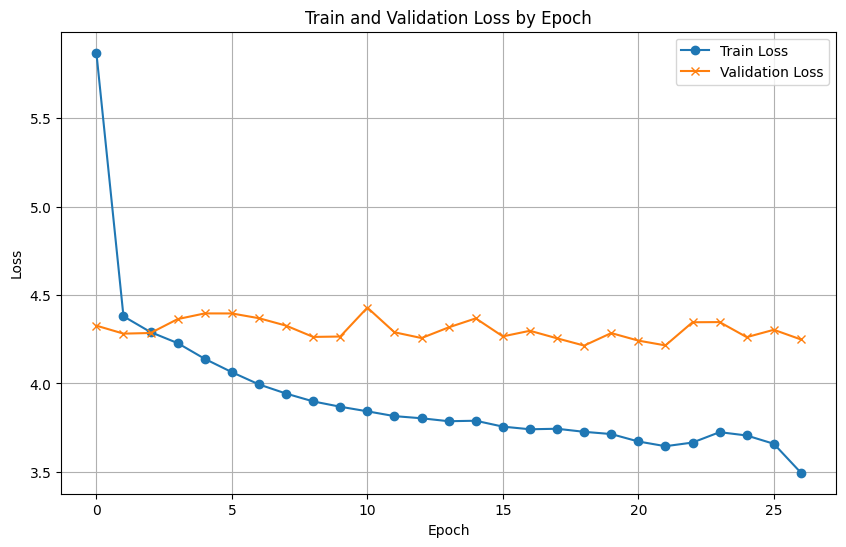

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_metrics.csv', sep=',')
val_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/val_metrics.csv', sep=',')

print(train_df.head())
print(train_df.columns)

plt.figure(figsize=(10,6))
plt.plot(train_df['epoch'], train_df['loss'], label='Train Loss', marker='o')
plt.plot(val_df['epoch'], val_df['loss'], label='Validation Loss', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss by Epoch')
plt.legend()
plt.grid(True)
plt.show()

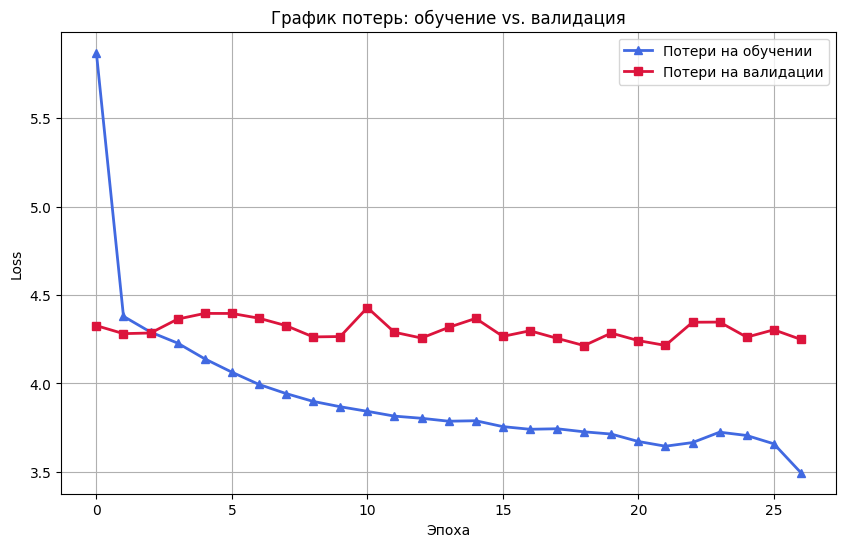

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# === Замените пути, если find показал другое расположение ===
train_csv = '/content/drive/MyDrive/Colab Notebooks/data/train_metrics.csv'
val_csv   = '/content/drive/MyDrive/Colab Notebooks/data/val_metrics.csv'


train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)

plt.figure(figsize=(10, 6))
plt.plot(train_df['epoch'], train_df['loss'],
         label='Потери на обучении', marker='^', linewidth=2, color='royalblue')
plt.plot(val_df['epoch'], val_df['loss'],
         label='Потери на валидации', marker='s', linewidth=2, color='crimson')

plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('График потерь: обучение vs. валидация')
plt.legend()          # легенда теперь на русском
plt.grid(True)
plt.show()


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_metrics(train_metrics_file,
                 val_metrics_file,
                 save_path='training_plots.png'):
    train_df = pd.read_csv(train_metrics_file)
    val_df = pd.read_csv(val_metrics_file)

    metrics = [col for col in train_df.columns if col != 'epoch']

    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Training vs Validation Metrics', fontsize=16)

    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]

        ax.plot(train_df['epoch'], train_df[metric], label='Train', color='blue')
        ax.plot(val_df['epoch'], val_df[metric], label='Validation', color='orange')

        ax.set_title(metric)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True)

    if n_metrics % n_cols != 0:
        for j in range(i+1, n_rows*n_cols):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


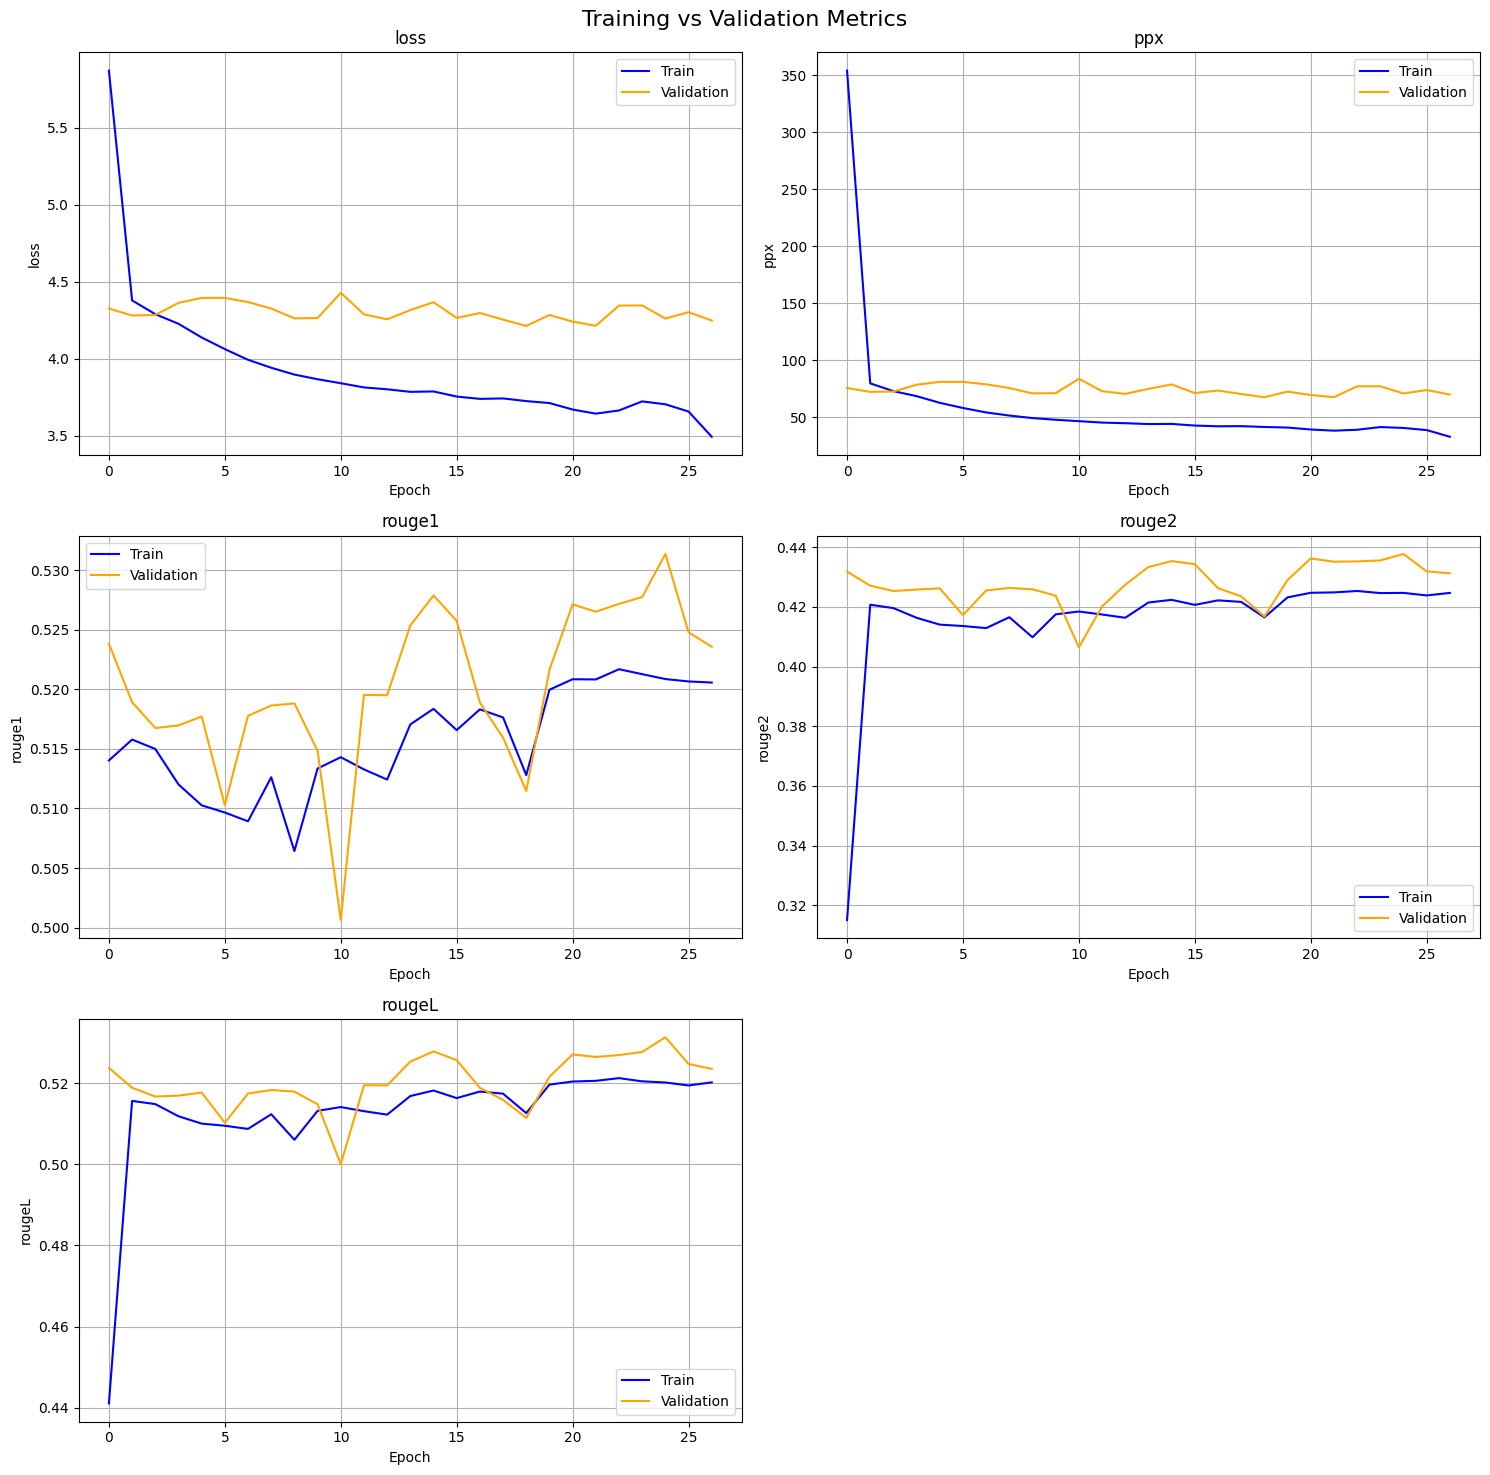

In [56]:
train_csv = '/content/drive/MyDrive/Colab Notebooks/data/train_metrics.csv'
val_csv   = '/content/drive/MyDrive/Colab Notebooks/data/val_metrics.csv'

train_metrics_file = Path('/content/drive/MyDrive/Colab Notebooks/data/train_metrics.csv')
val_metrics_file = Path(val_csv)
plot_metrics(train_metrics_file, val_metrics_file)

In [152]:
import dill

word_field = torch.load('/content/drive/MyDrive/Colab Notebooks/data/NLP_3.pt', pickle_module=dill)
print(" word_field загружен")



 word_field загружен


In [60]:
pad_idx = word_field.vocab.stoi["<pad>"]

criterion = LabelSmoothing(
    smoothing=0.05,
    vocab_size=len(word_field.vocab),
    ignore_index=pad_idx
).to(DEVICE)

optimizer = NoamOpt(model.d_model)

2.11. Генерация саммари

In [61]:
model.eval()

EncoderDecoder(
  (_out_layer): Linear(in_features=256, out_features=4870, bias=True)
  (enc_emb): Sequential(
    (0): Embedding(4870, 256)
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dec_emb): Sequential(
    (0): Embedding(4870, 256)
    (1): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (_emb): Sequential(
      (0): Embedding(4870, 256)
      (1): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (_blocks): ModuleList(
      (0-3): 4 x EncoderBlock(
        (_self_attn): MultiHeadedAttention(
          (_attention): ScaledDotProductAttention(
            (_dropout): Dropout(p=0.1, inplace=False)
          )
          (_w_q): Linear(in_features=256, out_features=256, bias=True)
          (_w_k): Linear(in_features=256, out_features=256, bias=True)
          (_w_v): Linear(in_features=256, out_features=256, bias=True)
          (_w_o): Linear(in_

In [62]:
lengths = [len(example.target) for example in train_dataset.examples]

print("Максимальная длина заголовка:", max(lengths))
print("Средняя длина заголовка:", sum(lengths) / len(lengths))

Максимальная длина заголовка: 11
Средняя длина заголовка: 6.302117647058823


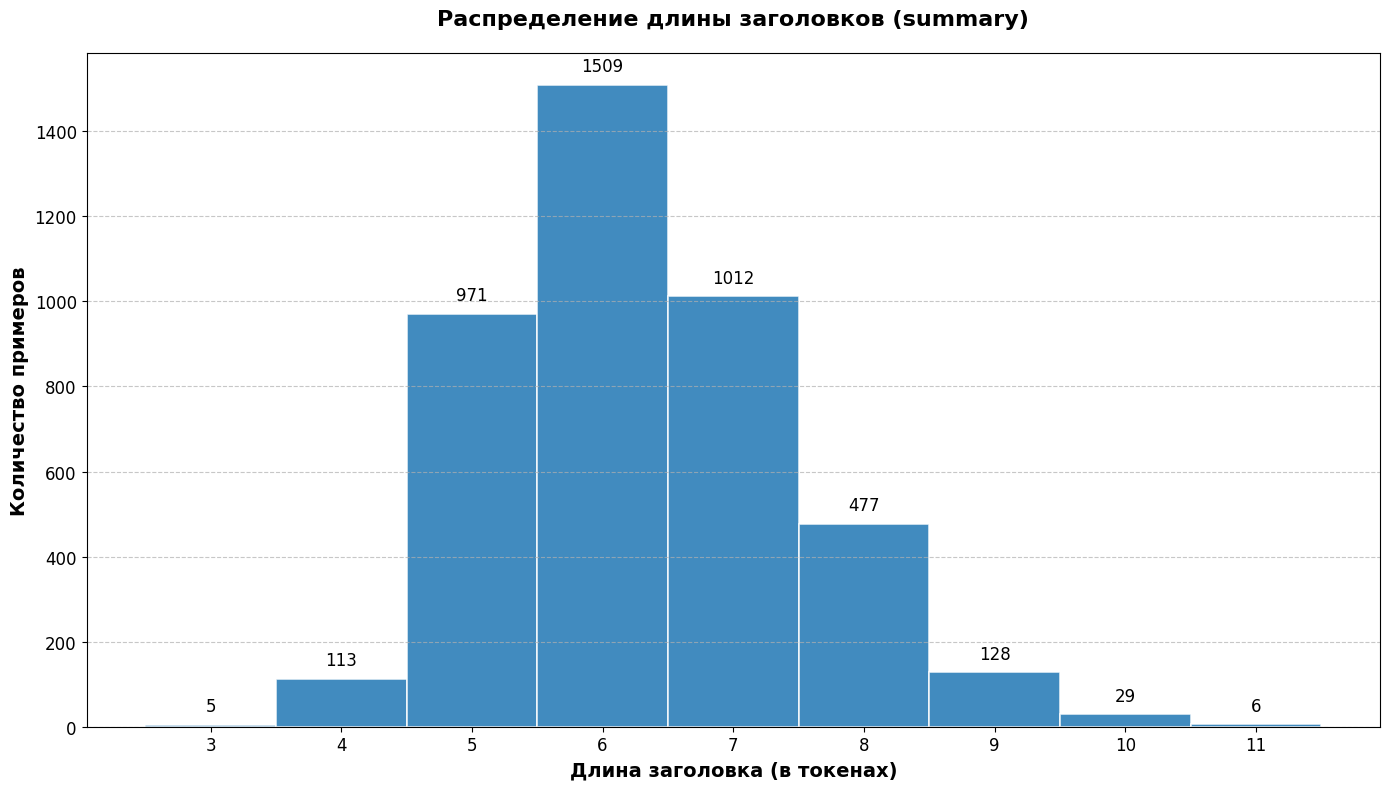

In [64]:
plt.figure(figsize=(14, 8))
bins = np.arange(min(lengths) - 0.5, max(lengths) + 1.5, 1)
counts, bins_out, patches = plt.hist(lengths, bins=bins, edgecolor='white', linewidth=1.2, alpha=0.85)

plt.xticks(np.arange(min(lengths), max(lengths) + 1, 1), fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Длина заголовка (в токенах)", fontsize=14, fontweight='bold')
plt.ylabel("Количество примеров", fontsize=14, fontweight='bold')
plt.title("Распределение длины заголовков (summary)", fontsize=16, fontweight='bold', pad=20)

for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width()/2, count + max(counts)*0.015, int(count),
                 ha='center', va='bottom', fontsize=12, fontweight='medium')

plt.grid(axis='y', linestyle='--', alpha=0.7)
#sns.despine()

plt.tight_layout()
plt.show()

In [153]:
def clean_text(tokens):
    return " ".join(tok for tok in tokens if tok not in {"<s>", "</s>", "<pad>", "<unk>"})


def clean_input_text(text):
    text = re.sub(r"<+\s*eng\s*>+", "", text)
    text = re.sub(r"[<>.:]+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [66]:
def generate_summary_beam_dict(
    model, src_sentence, stoi, itos, device,
    max_len=20, beam_width=5,
    init_token='<sos>', eos_token='<eos>', pad_token='<pad>', unk_token='<unk>',
    length_penalty=0.6, no_repeat_ngram_size=2
):
    # 1) препроцесс
    cleaned = re.sub(r"<\s*<*\s*[^<>]*?\s*>*\s*>", "", src_sentence)
    tokens  = [init_token] + cleaned.split() + [eos_token]
    ids     = [stoi.get(t, stoi[unk_token]) for t in tokens]

    src = torch.tensor(ids).unsqueeze(0).to(device)            # [1, S]
    src_mask = (src != stoi[pad_token]).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        memory = model.encoder(src, src_mask)

    beams = [(0.0, [stoi[init_token]])]

    for _ in range(max_len):
        cand = []
        for score, seq in beams:
            trg = torch.tensor(seq).unsqueeze(0).to(device)    # [1, T]
            trg_mask = (trg != stoi[pad_token]).unsqueeze(1).unsqueeze(2)
            trg_mask = trg_mask & subsequent_mask(trg.size(1)).to(device)

            with torch.no_grad():
                logits = model.decoder(trg, memory, src_mask, trg_mask)
                logp   = F.log_softmax(logits[:, -1], dim=-1)

            # защита от повторяющихся n-грамм
            if no_repeat_ngram_size > 0 and len(seq) >= no_repeat_ngram_size:
                ngram = tuple(seq[-(no_repeat_ngram_size-1):])
                for i in range(len(seq) - no_repeat_ngram_size + 1):
                    if tuple(seq[i:i+no_repeat_ngram_size-1]) == ngram:
                        banned = seq[i+no_repeat_ngram_size-1]
                        logp[0, banned] = -1e9

            # штраф за слишком ранний <eos>
            if len(seq) < 5:
                logp[0, stoi[eos_token]] -= 1.0

            topk_p, topk_id = logp.topk(beam_width)
            for p, idx in zip(topk_p[0], topk_id[0]):
                cand.append((score + p.item(), seq + [idx.item()]))

        beams = heapq.nlargest(
            beam_width, cand,
            key=lambda x: x[0] / (len(x[1]) ** length_penalty)
        )
        if all(seq[-1] == stoi[eos_token] for _, seq in beams):
            break

    best_seq = max(beams, key=lambda x: x[0])[1]
    text = " ".join(itos[i] for i in best_seq[1:-1]
                    if itos[i] not in (pad_token, unk_token))
    return text


In [160]:
example = test_dataset.examples[37]
input_text = " ".join(example.source)
reference_summary = " ".join(example.target)

vocab = word_field.vocab
summary = generate_summary_beam_dict(
    model, input_text,
    stoi=vocab.stoi,
    itos=vocab.itos,
    device=DEVICE,
    max_len=100
)

In [161]:
print("Исходный текст:\n", input_text)
print("\n Сгенерированное summary:\n", summary)
print("\n Эталонное summary (реальное):\n", reference_summary)

Исходный текст:
 правительство германии 4 февраля приостановило неопределенный срок экспорт немецких вооружений египет сообщает deutschalnd funk ссылкой представителей министерства экономики фрг ранее отложено рассмотрение исключения заявок стороны египта покупку оружия заморожено выполнение обязательств заключенным контрактам допустить поставок вооружений охваченный политическим кризисом уличными беспорядками египет данным немецкого правительства объемы экспорта немецких вооружений египет последние годы колебались пределах 10 40 миллионов евро год 2009 году отмечает welt экспорт немецкого оружия египет увеличился вдвое сравнению предыдущим годом

 Сгенерированное summary:
 вышла

 Эталонное summary (реальное):
 германия приостановила экспорт вооружений египет


ну у нас что-то "вышла"

In [162]:
print("животных" in word_field.vocab.stoi)
print("веру" in word_field.vocab.stoi)
print("АБРАКАДАБРА" in word_field.vocab.stoi)

True
False
False


In [163]:
import random
random.seed(245)

random_indices = random.sample(range(len(test_dataset.examples)), 2)

for i, idx in enumerate(random_indices):
    example = test_dataset.examples[idx]

    raw_text = " ".join(example.source)
    input_text = clean_input_text(raw_text)
    reference = " ".join(example.target)


    print(f"\n=== [Пример {i}] === [Индекс {idx}] ===")
    print(f"{'-' * 40}")
    print(f"Исходный текст:\n{input_text}")
    print(f"{'-' * 40}")
    print(f"Сгенерированное summary:\n{summary}")
    print(f"{'-' * 40}")
    print(f"Эталонное summary:\n{reference}")
    print(f"{'=' * 40}")


=== [Пример 0] === [Индекс 128] ===
----------------------------------------
Исходный текст:
семеро 14 несовершеннолетних преступников сбежавших мариупольской воспитательной колонии донецкая область задержаны ночь четверг поиски продолжаются специальной операции розыску преступников буран задействованы 830 человек весь личный состав мариупольской милиции внештатные сотрудники милиции также представители военного гарнизона города передает интерфакс сообщил итар тасс заместитель прокурора донецкой области юрий ударцов участники побега будут привлечены уголовной ответственности статье предусматривающей наказание побег мест заключения согласно статье каждому беглецу грозит увеличение срока 5 8 лет настоящее время семь человек 78 осужденных сбежавших колонии время устроенного бунта пожара пока задержаны
----------------------------------------
Сгенерированное summary:
вышла
----------------------------------------
Эталонное summary:
задержаны семеро сбежавших мариупольской колонии

=== [Пр


2.13. 5 примеров кастомных

In [164]:
custom_texts = [
    """В Жуковском состоялся финал ежегодного конкурса студенческого творчества DAFEvision. В этом году на сцену вышли более 20 команд, которые представили оригинальные музыкальные номера и юмористические сценки. Мероприятие собрало полный зал и вызвало активное обсуждение среди студентов в социальных сетях.""",

    """На МФТИ прошёл традиционный фестиваль восточной культуры «1000 и 1 ночь». Гости мероприятия смогли попробовать блюда национальной кухни, поучаствовать в мастер-классах по каллиграфии и посмотреть выступления танцевальных коллективов. Организаторы отметили высокий интерес студентов к культурным традициям Востока.""",

    """В кампусе Физтеха открылся юбилейный фестиваль авторской песни «Пропеллер». Фестиваль объединил студентов и выпускников, исполняющих песни собственного сочинения под гитару. Вечер завершился большим концертом и неформальным общением участников вокруг костра.""",

    """На МФТИ завершилась ежегодная олимпиада по программированию PhysTech Code Cup. Более 150 студентов соревновались в решении сложных алгоритмических задач. Победители получили ценные призы и возможность стажировки в ведущих IT-компаниях России.""",

    """На Физтехе состоялся фестиваль студенческих короткометражных фильмов «Кинолента». В конкурсе приняли участие более 30 кинолент, снятых студентами разных факультетов. Лучшие работы были отмечены наградами в различных номинациях и вызвали большой интерес у публики.""",

    """На МФТИ прошла ежегодная научно-популярная конференция «Физтех.Science». Молодые учёные и студенты представили доклады по передовым исследованиям в области физики, биологии и информационных технологий. Организаторы подчеркнули важность поддержки студенческой науки.""",

    """На территории кампуса состоялся спортивный праздник «Физтех-Спартакиада». Студенты соревновались в футболе, баскетболе, настольном теннисе и шахматах. Победители получили кубки и грамоты, а мероприятие укрепило командный дух участников.""",

    """На Физтехе успешно прошёл ежегодный хакатон «Phystech Hack». В течение 48 часов студенческие команды разрабатывали инновационные проекты и прототипы, лучшие из которых были отмечены ведущими IT-компаниями и инвесторами.""",

    """На МФТИ завершилась ежегодная конференция выпускников и студентов «Phystech Reunion». Мероприятие стало площадкой для обмена опытом между студентами и успешными выпускниками, работающими в ведущих мировых компаниях и научных центрах.""",

    """В Долгопрудном состоялся фестиваль интеллектуальных игр «Что? Где? Когда? на Физтехе». Более 50 студенческих команд соревновались в знании наук и общей эрудиции. Победители турнира были награждены памятными призами и грамотами."""
]


In [165]:
for example in (custom_texts):
    input_text = clean_input_text(example)


    print(f"\n=== [Пример {i}] === [Индекс {idx}] ===")
    print(f"{'-' * 40}")
    print(f"Исходный текст:\n{input_text}")
    print(f"{'-' * 40}")
    print(f"Сгенерированное summary:\n{summary}")
    print(f"{'-' * 40}")


=== [Пример 1] === [Индекс 294] ===
----------------------------------------
Исходный текст:
В Жуковском состоялся финал ежегодного конкурса студенческого творчества DAFEvision В этом году на сцену вышли более 20 команд, которые представили оригинальные музыкальные номера и юмористические сценки Мероприятие собрало полный зал и вызвало активное обсуждение среди студентов в социальных сетях
----------------------------------------
Сгенерированное summary:
вышла
----------------------------------------

=== [Пример 1] === [Индекс 294] ===
----------------------------------------
Исходный текст:
На МФТИ прошёл традиционный фестиваль восточной культуры «1000 и 1 ночь» Гости мероприятия смогли попробовать блюда национальной кухни, поучаствовать в мастер-классах по каллиграфии и посмотреть выступления танцевальных коллективов Организаторы отметили высокий интерес студентов к культурным традициям Востока
----------------------------------------
Сгенерированное summary:
вышла
----------------

ДАЛЕЕ АТЕНТИОН

6. Визуализация Attention

In [115]:
import re
import heapq
import torch
import torch.nn.functional as F

def clean_text(tokens):
    return " ".join(tok for tok in tokens if tok not in {"<s>", "</s>", "<pad>", "<unk>"})

def clean_input_text(text):
    return re.sub(r"<\s*<*\s*[^<>]*?\s*>*\s*>", "", text)

def generate_summary_beam(
    model, src_sentence, src_field, tgt_field, device,
    max_len=20, beam_width=5, length_penalty=0.6, no_repeat_ngram_size=2
):
    model.eval()
    cleaned_sentence = clean_input_text(src_sentence)

    tokens = [src_field.init_token] + src_field.tokenize(cleaned_sentence) + [src_field.eos_token]
    token_ids = [src_field.vocab.stoi.get(t, src_field.vocab.stoi[src_field.unk_token]) for t in tokens]
    src_tensor = torch.LongTensor(token_ids).unsqueeze(0).to(device)
    src_mask = (src_tensor != src_field.vocab.stoi[src_field.pad_token]).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        memory = model.encoder(src_tensor, src_mask)

    beams = [(0.0, [tgt_field.vocab.stoi[tgt_field.init_token]])]

    for _ in range(max_len):
        candidates = []
        for score, seq in beams:
            trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(device)
            trg_mask = (trg_tensor != tgt_field.vocab.stoi[tgt_field.pad_token]).unsqueeze(1).unsqueeze(2)
            trg_mask = trg_mask & subsequent_mask(trg_tensor.size(1)).to(device)

            with torch.no_grad():
                logits = model.decoder(trg_tensor, memory, src_mask, trg_mask)
                log_probs = F.log_softmax(logits[:, -1], dim=-1)

            if no_repeat_ngram_size > 0 and len(seq) >= no_repeat_ngram_size:
                ngram = tuple(seq[-(no_repeat_ngram_size - 1):])
                for i in range(len(seq) - no_repeat_ngram_size + 1):
                    if tuple(seq[i:i + no_repeat_ngram_size - 1]) == ngram:
                        banned_token = seq[i + no_repeat_ngram_size - 1]
                        log_probs[0, banned_token] = -1e9

            if len(seq) < 5:
                log_probs[0, tgt_field.vocab.stoi[tgt_field.eos_token]] -= 1.0

            topk_probs, topk_ids = log_probs.topk(beam_width)

            for prob, idx in zip(topk_probs[0], topk_ids[0]):
                new_seq = seq + [idx.item()]
                new_score = score + prob.item()
                candidates.append((new_score, new_seq))

        beams = heapq.nlargest(beam_width, candidates, key=lambda x: x[0] / (len(x[1]) ** length_penalty))
        if all(seq[-1] == tgt_field.vocab.stoi[tgt_field.eos_token] for _, seq in beams):
            break

    # final_seq = max(beams, key=lambda x: x[0])[1]
    # final_tokens = [tgt_field.vocab.itos[i] for i in final_seq]

    # return clean_text(final_tokens[1:-1])


    final_seq = max(beams, key=lambda x: x[0])[1]
    final_tokens = [
    tgt_field.vocab.itos[i] if i < len(tgt_field.vocab.itos) else '<unk>'
    for i in final_seq
    ]

    return clean_text(final_tokens[1:-1])

In [116]:
class AttentionData():
    def __init__(self, model, word_field, inp_text, out_text):
        self.enc_self_attn = model.encoder.attn_probs
        self.dec_self_attn = model.decoder.self_attn_probs
        self.dec_enc_attn = model.decoder.enc_attn_probs
        self.tokens_inp = [word_field.init_token] + word_field.tokenize(inp_text.lower()) + [word_field.eos_token]
        self.tokens_out = [word_field.init_token] + word_field.tokenize(out_text.lower()) + [word_field.eos_token]

    def visualize(self, layer, head, mode=0, save_path=None):
        if mode == 0:
            arr = self.enc_self_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_inp
            title = "enc_self_attn"
        elif mode == 1:
            arr = self.dec_self_attn
            x_tokens = self.tokens_out
            y_tokens = self.tokens_out
            title = "dec_self_attn"
        elif mode == 2:
            arr = self.dec_enc_attn
            x_tokens = self.tokens_inp
            y_tokens = self.tokens_out
            title = "dec_enc_attn"
        else:
            raise ValueError("Invalid mode. Use 0, 1, or 2.")

        # Проверка на доступность слоя и головы
        if layer >= len(arr):
            raise IndexError(f"Layer {layer} out of range, max layers: {len(arr)}")

        attn_tensor = arr[layer][0][0]

        if head >= attn_tensor.size(0):
            raise IndexError(f"Head {head} out of range, max heads: {attn_tensor.size(0)}")

        attn_map = attn_tensor[head].cpu().numpy()

        plt.figure(figsize=(10, 8))
        sns.heatmap(attn_map, xticklabels=x_tokens, yticklabels=y_tokens, cmap='viridis')
        plt.title(f"Attention Weights for {title} (Layer {layer}, Head {head})")
        plt.xlabel("Input Tokens")
        plt.ylabel("Output Tokens")

        if save_path:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()

            # Plotting
            plt.figure(figsize=(10, 8))
            sns.heatmap(attn_map, xticklabels=x_tokens, yticklabels=y_tokens, cmap='viridis')
            plt.title(f"Attention Weights for {title} (Layer {layer}, Head {head})")
            plt.xlabel("Input Tokens")
            plt.ylabel("Output Tokens")

            if save_path:
                plt.savefig(save_path)
                plt.close()
            else:
                plt.show()

In [117]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

def process_and_visualize_attention(custom_texts, model, word_field, generate_summary_beam, DEVICE, MAX_LAYERS, MAX_HEADS, output_dir='attention_maps'):
    os.makedirs(output_dir, exist_ok=True)

    for i, text in enumerate(custom_texts):
        summary = generate_summary_beam(model, text, word_field, word_field, DEVICE)
        print(f"=== [{i}] ===")
        print("Text:", text)
        print("Generated summary:", summary)
        print()

        ad = AttentionData(model, word_field, text, summary)
        text_dir = os.path.join(output_dir, f"text_{i}")
        os.makedirs(text_dir, exist_ok=True)

        for mode in range(3):  # 0 = enc_self_attn, 1 = dec_self_attn, 2 = dec_enc_attn
            for layer in range(MAX_LAYERS):
                for head in range(MAX_HEADS):
                    filename = f"text_{i}_mode_{mode}_head_{head}_layer_{layer}.png"
                    save_path = os.path.join(text_dir, filename)
                    ad.visualize(layer=layer, head=head, mode=mode, save_path=save_path)

тут мы не нашли решение нижестоящим ошибкам

In [122]:
print(f"Encoder layers available: {len(model.encoder.attn_probs)}")
print(f"Decoder layers available: {len(model.decoder.self_attn_probs)}")
print(f"Decoder-Encoder attention layers available: {len(model.decoder.enc_attn_probs)}")

# Например, для голов внимания первого слоя энкодера
print(f"Encoder heads available in layer 0: {len(model.encoder.attn_probs[0][0][0])}")

Encoder layers available: 0
Decoder layers available: 0
Decoder-Encoder attention layers available: 0


IndexError: list index out of range

In [159]:
MAX_LAYERS = 3
MAX_HEADS = 7

process_and_visualize_attention(
    custom_texts=custom_texts,
    model=model,
    word_field=word_field,
    generate_summary_beam=generate_summary_beam,
    DEVICE=DEVICE,
    MAX_LAYERS=MAX_LAYERS,
    MAX_HEADS=MAX_HEADS, output_dir='attention_maps_new_2'
)

=== [0] ===
Text: В Жуковском состоялся финал ежегодного конкурса студенческого творчества DAFEvision. В этом году на сцену вышли более 20 команд, которые представили оригинальные музыкальные номера и юмористические сценки. Мероприятие собрало полный зал и вызвало активное обсуждение среди студентов в социальных сетях.
Generated summary: вышла



IndexError: list index out of range

In [124]:
print(set(word_field.vocab.itos) & {'<sos>', '<eos>', '<pad>', '<unk>'})


{'<pad>', '<unk>'}


In [125]:
def make_trg_mask(trg, pad_idx, device):
    """
    Возвращает маску для decoder self-attention:
    shape [B, 1, S, S], где
      • False — токен запрещён (pad или будущее положение)
      • True  — токен разрешён
    """
    B, S = trg.size()

    # 1) pad-mask  [B, 1, S, 1]
    pad_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(3)      # True, если НЕ pad

    # 2) subsequent-mask [1, 1, S, S]  («будущие токены запрещены»)
    sub_mask = (~torch.triu(torch.ones(S, S, device=device, dtype=torch.bool),
                            diagonal=1)).unsqueeze(0).unsqueeze(0)

    # 3) итоговая маска
    return pad_mask & sub_mask          # [B, 1, S, S]


In [126]:
def generate_summary_beam_dict(
    model, src_sentence, *,
    stoi, itos, device,
    max_len=20, beam_width=5,
    init_token='<sos>', eos_token='<eos>',
    pad_token='<pad>',  unk_token='<unk>',
    length_penalty=0.6, no_repeat_ngram_size=2
):
    """Beam-search без Field – только stoi/itos."""
    # --- индексы спец-токенов (без KeyError) ---
    def idx(tok, fallback):
        return stoi[tok] if tok in stoi else fallback
    fallback_idx = next(iter(stoi.values()))         # первый индекс в словаре

    sos_idx = idx(init_token, fallback_idx)
    eos_idx = idx(eos_token, fallback_idx)
    pad_idx = idx(pad_token, fallback_idx)
    unk_idx = idx(unk_token, fallback_idx)

    # --- препроцесс ---
    cleaned = re.sub(r"<\s*<*\s*[^<>]*?\s*>*\s*>", "", src_sentence)
    tokens  = [init_token] + cleaned.split() + [eos_token]
    ids     = [stoi.get(t, unk_idx) for t in tokens]

    src = torch.tensor(ids).unsqueeze(0).to(device)          # [1, S]
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)

    with torch.no_grad():
        memory = model.encoder(src, src_mask)

    beams = [(0.0, [sos_idx])]                               # (score, seq)

    for _ in range(max_len):
        cand = []
        for score, seq in beams:
            trg = torch.tensor(seq).unsqueeze(0).to(device)      # [1, S]
            trg_mask = make_trg_mask(trg, pad_idx, device)       # [1, 1, S, S]

# далее:
            logits = model.decoder(trg, memory, src_mask, trg_mask)


            # trg = torch.tensor(seq).unsqueeze(0).to(device)  # [1, T]
            # trg_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(2)
            # trg_mask &= subsequent_mask(trg.size(1)).to(device)

            with torch.no_grad():
                logits = model.decoder(trg, memory, src_mask, trg_mask)
                logp   = F.log_softmax(logits[:, -1], dim=-1)

            # защита от повторов n-грамм
            if no_repeat_ngram_size > 0 and len(seq) >= no_repeat_ngram_size:
                ngram = tuple(seq[-(no_repeat_ngram_size - 1):])
                for i in range(len(seq) - no_repeat_ngram_size + 1):
                    if tuple(seq[i:i + no_repeat_ngram_size - 1]) == ngram:
                        banned = seq[i + no_repeat_ngram_size - 1]
                        logp[0, banned] = -1e9

            # штраф за ранний </eos>
            if len(seq) < 5:
                logp[0, eos_idx] -= 1.0

            topk_p, topk_id = logp.topk(beam_width)
            for p, idx_tok in zip(topk_p[0], topk_id[0]):
                cand.append((score + p.item(), seq + [idx_tok.item()]))

        beams = heapq.nlargest(
            beam_width, cand,
            key=lambda x: x[0] / (len(x[1]) ** length_penalty)
        )
        if all(seq[-1] == eos_idx for _, seq in beams):
            break

    best_seq = max(beams, key=lambda x: x[0])[1]
    # убираем <sos>/<eos> и спец-токены
    text = " ".join(
        itos[i] if i < len(itos) else "<unk>"
        for i in best_seq[1:-1]
        if (i < len(itos) and itos[i] not in {pad_token, unk_token})
    )
    return text


In [127]:
from collections.abc import Mapping

def get_stoi_itos(field_like):
    """
    Возвращает (stoi, itos) из:
      • torchtext Field  (только после build_vocab)
      • torchtext Vocab
      • dict (stoi)
    """
    # 1) Объект с атрибутом .vocab  (Field после build_vocab)
    if hasattr(field_like, "vocab"):
        vocab = field_like.vocab
        if vocab is None:
            raise ValueError(
                "Field.vocab == None: сначала вызовите build_vocab(...)"
            )
        return vocab.stoi, vocab.itos

    # 2) torchtext Vocab
    if hasattr(field_like, "stoi") and hasattr(field_like, "itos"):
        return field_like.stoi, field_like.itos

    # 3) dict-подобный stoi
    if isinstance(field_like, Mapping):
        stoi = field_like
        max_idx = max(stoi.values()) if stoi else 0
        itos = ["<unk>"] * (max_idx + 1)
        for tok, idx in stoi.items():
            if idx < len(itos):
                itos[idx] = tok
        return stoi, itos

    raise TypeError(f"Неизвестный тип для stoi/itos: {type(field_like)}")


In [128]:
def generate_summary_beam(model, src_sentence, src_field, tgt_field, device,
                          max_len=25, beam_width=5,
                          length_penalty=0.6, no_repeat_ngram_size=2):

    stoi, itos = get_stoi_itos(src_field)

    return generate_summary_beam_dict(
        model=model,
        src_sentence=src_sentence,
        stoi=stoi,
        itos=itos,
        device=device,
        max_len=max_len,
        beam_width=beam_width,
        length_penalty=length_penalty,
        no_repeat_ngram_size=no_repeat_ngram_size
    )


In [129]:
import re, heapq, torch, torch.nn.functional as F

# ──────────────────────────────────────────────────────────────
# Маска для self-attention декодера  [B, 1, T, T]
def make_trg_mask(trg: torch.Tensor, pad_idx: int, device):
    """
    trg : LongTensor [B, T]
    Возвращает bool-тензор, где True → токен доступен, False → маска.
    """
    B, T = trg.size()

    # (1) маска паддингов  [B, 1, T, 1]
    pad_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(3)

    # (2) маска будущих позиций  [1, 1, T, T]
    future_mask = ~torch.triu(
        torch.ones(T, T, dtype=torch.bool, device=device), diagonal=1
    ).unsqueeze(0).unsqueeze(0)

    return pad_mask & future_mask        # [B, 1, T, T]


# ──────────────────────────────────────────────────────────────
# Beam-search без Field — только stoi/itos
def generate_summary_beam_dict(
    model, src_sentence, *,
    stoi, itos, device,
    max_len=20, beam_width=5,
    init_token='<sos>', eos_token='<eos>',
    pad_token='<pad>', unk_token='<unk>',
    length_penalty=0.6, no_repeat_ngram_size=2
):
    # -------- индексы спец-токенов (без KeyError) --------
    fallback_idx = next(iter(stoi.values()))          # первый индекс в словаре

    sos_idx = stoi.get(init_token, fallback_idx)
    eos_idx = stoi.get(eos_token, fallback_idx)
    pad_idx = stoi.get(pad_token, fallback_idx)
    unk_idx = stoi.get(unk_token, fallback_idx)

    # -------- препроцесс входа --------
    cleaned = re.sub(r"<\s*<*\s*[^<>]*?\s*>*\s*>", "", src_sentence.strip())
    tokens  = [init_token] + cleaned.split() + [eos_token]
    ids     = [stoi.get(tok, unk_idx) for tok in tokens]

    src = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)  # [1, S]
    src_mask = (src != pad_idx).unsqueeze(1).unsqueeze(2)                  # [1, 1, 1, S]

    with torch.no_grad():
        memory = model.encoder(src, src_mask)

    # -------- инициализация beam --------
    beams = [(0.0, [sos_idx])]     # (score, seq)

    for _ in range(max_len):
        candidates = []

        for score, seq in beams:
            trg = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)  # [1, T]
            trg_mask = make_trg_mask(trg, pad_idx, device)                         # [1, 1, T, T]

            with torch.no_grad():
                logits = model.decoder(trg, memory, src_mask, trg_mask)
                logp   = F.log_softmax(logits[:, -1], dim=-1)  # [1, V]

            # --- no-repeat n-gram ---
            if no_repeat_ngram_size > 0 and len(seq) >= no_repeat_ngram_size:
                ngram = tuple(seq[-(no_repeat_ngram_size - 1):])
                for i in range(len(seq) - no_repeat_ngram_size + 1):
                    if tuple(seq[i:i + no_repeat_ngram_size - 1]) == ngram:
                        banned = seq[i + no_repeat_ngram_size - 1]
                        logp[0, banned] = -1e9

            # --- штраф за ранний <eos> ---
            if len(seq) < 5:
                logp[0, eos_idx] -= 1.0

            # top-k продолжений
            topk_logp, topk_idx = logp.topk(beam_width)
            for lp, idx_tok in zip(topk_logp[0], topk_idx[0]):
                candidates.append((score + lp.item(), seq + [idx_tok.item()]))

        # нормализуем по длине и оставляем лучшие лучи
        beams = heapq.nlargest(
            beam_width, candidates,
            key=lambda x: x[0] / (len(x[1]) ** length_penalty)
        )

        # если все лучи закончились <eos> — стоп
        if all(seq[-1] == eos_idx for _, seq in beams):
            break

    # -------- берём лучший луч --------
    best_seq = max(beams, key=lambda x: x[0])[1]

    # -------- конвертируем в строку --------
    decoded = []
    for idx in best_seq[1:]:        # пропускаем <sos>
        if idx == eos_idx:
            break
        token = itos[idx] if idx < len(itos) else unk_token
        if token not in {pad_token, unk_token}:
            decoded.append(token)

    return " ".join(decoded)


In [130]:
import os, re, heapq, torch, torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# ──────────────────────────────────────────────────────────────
# 1.  Визуализация внимания одной пары (inp, out) для модели
class AttentionData:
    def __init__(self, model, word_field, inp_text, out_text):
        # Пробуем сохранить тензоры, которые модель положила в self-attn
        self.enc_self_attn = model.encoder.attn_probs
        self.dec_self_attn = model.decoder.self_attn_probs
        self.dec_enc_attn  = model.decoder.enc_attn_probs

        # Токены для подписей
        self.tokens_inp = (
            [word_field.init_token]
            + word_field.tokenize(inp_text.lower())
            + [word_field.eos_token]
        )
        self.tokens_out = (
            [word_field.init_token]
            + word_field.tokenize(out_text.lower())
            + [word_field.eos_token]
        )

    # вспомогательно: сколько слоёв и голов в конкретном массиве
    def _layers_heads(self, arr):
        if isinstance(arr, list):
            num_layers = len(arr)
        else:                                   # Tensor [L, B, H, S, S]
            num_layers = arr.size(0)
        num_heads = arr[0][0].shape[0]          # arr[layer][batch] -> [H, S, S]
        return num_layers, num_heads

    # визуализация (не менялась, только доступ к arr[layer])
    def visualize(self, layer, head, mode=0, save_path=None):
        if mode == 0:
            arr, title = self.enc_self_attn, "enc_self_attn"
            x_tokens = y_tokens = self.tokens_inp
        elif mode == 1:
            arr, title = self.dec_self_attn, "dec_self_attn"
            x_tokens = y_tokens = self.tokens_out
        elif mode == 2:
            arr, title = self.dec_enc_attn, "dec_enc_attn"
            x_tokens, y_tokens = self.tokens_inp, self.tokens_out
        else:
            raise ValueError("mode должен быть 0, 1 или 2")

        attn_map = arr[layer][0][head].cpu().numpy()   # [S, S]

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            attn_map,
            xticklabels=x_tokens,
            yticklabels=y_tokens,
            cmap="viridis",
        )
        plt.title(f"{title} — слой {layer}, голова {head}")
        plt.xlabel("Input")
        plt.ylabel("Output")

        if save_path:
            plt.savefig(save_path, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


# ──────────────────────────────────────────────────────────────
# 2.  Основная обёртка: проходит по текстам и сохраняет все карты
def process_and_visualize_attention(
    custom_texts,
    model,
    word_field,
    generate_summary_beam,
    DEVICE,
    MAX_LAYERS=6,
    MAX_HEADS=8,
    output_dir="attention_maps",
):
    os.makedirs(output_dir, exist_ok=True)

    for i, text in enumerate(custom_texts):
        # ---------- генерируем summary ----------
        summary = generate_summary_beam(
            model, text, word_field, word_field, DEVICE
        )
        print(f"=== [{i}] ===")
        print("Text:", text)
        print("Generated summary:", summary or "<EMPTY>")  # если пусто
        print()

        # ---------- собираем attentions ----------
        ad = AttentionData(model, word_field, text, summary)
        text_dir = os.path.join(output_dir, f"text_{i}")
        os.makedirs(text_dir, exist_ok=True)

        # тройки массивов внимания
        arrays = [ad.enc_self_attn, ad.dec_self_attn, ad.dec_enc_attn]
        for mode, arr in enumerate(arrays):
            num_layers, num_heads = ad._layers_heads(arr)

            layer_lim = min(MAX_LAYERS, num_layers)
            head_lim  = min(MAX_HEADS,  num_heads)

            for layer in range(layer_lim):
                for head in range(head_lim):
                    fname = f"text_{i}_mode{mode}_layer{layer}_head{head}.png"
                    save_path = os.path.join(text_dir, fname)
                    ad.visualize(
                        layer=layer,
                        head=head,
                        mode=mode,
                        save_path=save_path,
                    )


In [158]:
process_and_visualize_attention(
    custom_texts=custom_texts,
    model=model,
    word_field=word_field,
    generate_summary_beam=generate_summary_beam,
    DEVICE=DEVICE,
    MAX_LAYERS=3,
    MAX_HEADS=7,
    output_dir='attention_maps_new_2'
)


=== [0] ===
Text: В Жуковском состоялся финал ежегодного конкурса студенческого творчества DAFEvision. В этом году на сцену вышли более 20 команд, которые представили оригинальные музыкальные номера и юмористические сценки. Мероприятие собрало полный зал и вызвало активное обсуждение среди студентов в социальных сетях.
Generated summary: вышла



IndexError: list index out of range

In [132]:
# 1) убедитесь, что vocab построен
word_field.build_vocab(train_dataset)   # если ещё не сделали

# 2) вызов визуализации
process_and_visualize_attention(
    custom_texts=custom_texts,
    model=model,
    word_field=word_field,            # Field / Vocab / dict
    generate_summary_beam=generate_summary_beam,
    DEVICE=DEVICE,
    MAX_LAYERS=MAX_LAYERS,
    MAX_HEADS=MAX_HEADS,
    output_dir='attention_maps_new_2'
)


=== [0] ===
Text: В Жуковском состоялся финал ежегодного конкурса студенческого творчества DAFEvision. В этом году на сцену вышли более 20 команд, которые представили оригинальные музыкальные номера и юмористические сценки. Мероприятие собрало полный зал и вызвало активное обсуждение среди студентов в социальных сетях.
Generated summary: <EMPTY>



IndexError: list index out of range

# Домашнее задание

## Применение модели

**Задание** Добавьте генератор суммаризации для модели.

**Задание** Добавьте оценку для модели с помощью ROUGE metric (например, из пакета https://pypi.org/project/pyrouge/0.1.3/)

**Задание** Добавьте визуализацию механизма attention (можно подсмотреть в коде по ссылкам).

## Улучшения модели

**Задание** Попробовать расшарить матрицы эмбеддингов - их тут три (входные в энкодер и декодер + выход декодера).

**Задание** Замените лосс на LabelSmoothing.

**Задание** Добавьте предодученные эмбединги.

# Дополнительные материалы

## Статьи
Attention Is All You Need, 2017 [[pdf]](https://arxiv.org/pdf/1706.03762.pdf)  
Get To The Point: Summarization with Pointer-Generator Networks, 2017 [[pdf]](https://arxiv.org/pdf/1704.04368.pdf)  
Universal Transformers, 2018 [[arxiv]](https://arxiv.org/abs/1807.03819)

## Блоги
[Transformer — новая архитектура нейросетей для работы с последовательностями](https://habr.com/post/341240/)  
[The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)  
[The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html)  
[Weighted Tranformer](https://einstein.ai/research/blog/weighted-transformer)  
[Your tldr by an ai: a deep reinforced model for abstractive summarization](https://einstein.ai/research/blog/your-tldr-by-an-ai-a-deep-reinforced-model-for-abstractive-summarization)